In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

from PIL import Image, ImageDraw, ImageFont
import arabic_reshaper
from bidi.algorithm import get_display

from collections import deque

import psutil
import time

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model - to detect the points
mp_drawing = mp.solutions.drawing_utils # Drawing utilities - to draw the points

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable - saves a little bit to memory
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

In [5]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [6]:
def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(255,0,0), thickness=2, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(255,255,250), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=2)
                             ) 

# Preparing Data - Approach 1: Padding/Truncating to fixed length

In [7]:
# "Variable_Length_Sequences" directory contains the sequences extracted from the videos with their original length
# so what will be done in order to create training data for each of the LSTMS is that we'll pad/truncate to desired length
sequence_dir = 'Variable_Length_Sequences'

## Sequences-length 30

In [8]:
# Define the desired sequence length
sequence_length = 30

features_30 = [] 
labels_30 = []

for word_folder in os.listdir(sequence_dir):
    word_sequence_dir = os.path.join(sequence_dir, word_folder)
    if os.path.isdir(word_sequence_dir):
        for npy_file in os.listdir(word_sequence_dir):
            if npy_file.endswith('.npy'):
                npy_filepath = os.path.join(word_sequence_dir, npy_file)
                keypoints_sequence = np.load(npy_filepath)
                
                # Truncate or pad sequences to the desired length
                if len(keypoints_sequence) < sequence_length:
                    # Pad the sequence with zeros to reach the desired length
                    padding_length = sequence_length - len(keypoints_sequence)
                    padded_sequence = np.pad(keypoints_sequence, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
                    features_30.append(padded_sequence)
                else:
                    # Truncate the sequence to the desired length
                    truncated_sequence = keypoints_sequence[:sequence_length]
                    features_30.append(truncated_sequence)
                    
                labels_30.append(word_folder) 


In [9]:
X_30 = np.array(features_30)

print("X_30 shape:", X_30.shape)

X_30 shape: (5887, 30, 258)


In [10]:
label_encoder = LabelEncoder()
# Fit label encoder and transform labels to integers
y_30 = label_encoder.fit_transform(labels_30)
y_30 = np.array(y_30)
y_30

array([ 0,  0,  0, ..., 13, 13, 13], dtype=int64)

In [11]:
X30_train, X30_test, y30_train, y30_test = train_test_split(X_30, y_30, test_size=0.2, random_state=42,stratify=y_30)

## Sequence-length 60

In [8]:
# Define the desired sequence length
sequence_length_60 = 60

features_60 = [] 
labels_60 = []

for word_folder in os.listdir(sequence_dir):
    word_sequence_dir = os.path.join(sequence_dir, word_folder)
    if os.path.isdir(word_sequence_dir):
        for npy_file in os.listdir(word_sequence_dir):
            if npy_file.endswith('.npy'):
                npy_filepath = os.path.join(word_sequence_dir, npy_file)
                keypoints_sequence = np.load(npy_filepath)
                
                # Truncate or pad sequences to the desired length
                if len(keypoints_sequence) < sequence_length_60:
                    # Pad the sequence with zeros to reach the desired length
                    padding_length = sequence_length_60 - len(keypoints_sequence)
                    padded_sequence = np.pad(keypoints_sequence, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
                    features_60.append(padded_sequence)
                else:
                    # Truncate the sequence to the desired length
                    truncated_sequence = keypoints_sequence[:sequence_length_60]
                    features_60.append(truncated_sequence)
                    
                labels_60.append(word_folder) 

In [9]:
X_60 = np.array(features_60)

print("X_60 shape:", X_60.shape)

X_60 shape: (5887, 60, 258)


In [10]:
label_encoder = LabelEncoder()
# Fit label encoder and transform labels to integers
y_60 = label_encoder.fit_transform(labels_60)
y_60 = np.array(y_60)
y_60

array([ 0,  0,  0, ..., 13, 13, 13], dtype=int64)

In [12]:
X60_train, X60_test, y60_train, y60_test = train_test_split(X_60, y_60, test_size=0.2, random_state=42,stratify=y_60)

## Sequence-length 40

In [38]:
# Define the desired sequence length
sequence_length_40 = 40

features_40 = [] 
labels_40 = []

for word_folder in os.listdir(sequence_dir):
    word_sequence_dir = os.path.join(sequence_dir, word_folder)
    if os.path.isdir(word_sequence_dir):
        for npy_file in os.listdir(word_sequence_dir):
            if npy_file.endswith('.npy'):
                npy_filepath = os.path.join(word_sequence_dir, npy_file)
                keypoints_sequence = np.load(npy_filepath)
                
                # Truncate or pad sequences to the desired length
                if len(keypoints_sequence) < sequence_length_40:
                    # Pad the sequence with zeros to reach the desired length
                    padding_length = sequence_length_40 - len(keypoints_sequence)
                    padded_sequence = np.pad(keypoints_sequence, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
                    features_40.append(padded_sequence)
                else:
                    # Truncate the sequence to the desired length
                    truncated_sequence = keypoints_sequence[:sequence_length_40]
                    features_40.append(truncated_sequence)
                    
                labels_40.append(word_folder) 

In [39]:
X_40 = np.array(features_40)

print("X_40 shape:", X_40.shape)

X_40 shape: (5887, 40, 258)


In [40]:
label_encoder = LabelEncoder()
# Fit label encoder and transform labels to integers
y_40 = label_encoder.fit_transform(labels_40)
y_40 = np.array(y_40)
y_40

array([ 0,  0,  0, ..., 13, 13, 13], dtype=int64)

In [41]:
X40_train, X40_test, y40_train, y40_test = train_test_split(X_40, y_40, test_size=0.2, random_state=42,stratify=y_40)

## Sequence-length 50

In [32]:
# Define the desired sequence length
sequence_length_50 = 50

features_50 = [] 
labels_50 = []

for word_folder in os.listdir(sequence_dir):
    word_sequence_dir = os.path.join(sequence_dir, word_folder)
    if os.path.isdir(word_sequence_dir):
        for npy_file in os.listdir(word_sequence_dir):
            if npy_file.endswith('.npy'):
                npy_filepath = os.path.join(word_sequence_dir, npy_file)
                keypoints_sequence = np.load(npy_filepath)
                
                # Truncate or pad sequences to the desired length
                if len(keypoints_sequence) < sequence_length_50:
                    # Pad the sequence with zeros to reach the desired length
                    padding_length = sequence_length_50 - len(keypoints_sequence)
                    padded_sequence = np.pad(keypoints_sequence, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
                    features_50.append(padded_sequence)
                else:
                    # Truncate the sequence to the desired length
                    truncated_sequence = keypoints_sequence[:sequence_length_50]
                    features_50.append(truncated_sequence)
                    
                labels_50.append(word_folder) 

In [33]:
X_50 = np.array(features_50)

print("X_50 shape:", X_50.shape)

X_50 shape: (5887, 50, 258)


In [34]:
label_encoder = LabelEncoder()
# Fit label encoder and transform labels to integers
y_50 = label_encoder.fit_transform(labels_50)
y_50 = np.array(y_50)
y_50

array([ 0,  0,  0, ..., 13, 13, 13], dtype=int64)

In [35]:
X50_train, X50_test, y50_train, y50_test = train_test_split(X_50, y_50, test_size=0.2, random_state=42,stratify=y_50)

## Sequence-length 45

In [23]:
# Define the desired sequence length
sequence_length_45 = 45

features_45 = [] 
labels_45 = []

for word_folder in os.listdir(sequence_dir):
    word_sequence_dir = os.path.join(sequence_dir, word_folder)
    if os.path.isdir(word_sequence_dir):
        for npy_file in os.listdir(word_sequence_dir):
            if npy_file.endswith('.npy'):
                npy_filepath = os.path.join(word_sequence_dir, npy_file)
                keypoints_sequence = np.load(npy_filepath)
                
                # Truncate or pad sequences to the desired length
                if len(keypoints_sequence) < sequence_length_45:
                    # Pad the sequence with zeros to reach the desired length
                    padding_length = sequence_length_45 - len(keypoints_sequence)
                    padded_sequence = np.pad(keypoints_sequence, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
                    features_45.append(padded_sequence)
                else:
                    # Truncate the sequence to the desired length
                    truncated_sequence = keypoints_sequence[:sequence_length_45]
                    features_45.append(truncated_sequence)
                    
                labels_45.append(word_folder) 

In [24]:
X_45 = np.array(features_45)

print("X_45 shape:", X_45.shape)

X_45 shape: (5887, 45, 258)


In [25]:
label_encoder = LabelEncoder()
# Fit label encoder and transform labels to integers
y_45 = label_encoder.fit_transform(labels_45)
y_45 = np.array(y_45)
y_45

array([ 0,  0,  0, ..., 13, 13, 13], dtype=int64)

In [26]:
X45_train, X45_test, y45_train, y45_test = train_test_split(X_45, y_45, test_size=0.2, random_state=42,stratify=y_45)

## Sequence-length 35

In [61]:
# Define the desired sequence length
sequence_length_35 = 35

features_35 = [] 
labels_35 = []

for word_folder in os.listdir(sequence_dir):
    word_sequence_dir = os.path.join(sequence_dir, word_folder)
    if os.path.isdir(word_sequence_dir):
        for npy_file in os.listdir(word_sequence_dir):
            if npy_file.endswith('.npy'):
                npy_filepath = os.path.join(word_sequence_dir, npy_file)
                keypoints_sequence = np.load(npy_filepath)
                
                # Truncate or pad sequences to the desired length
                if len(keypoints_sequence) < sequence_length_35:
                    # Pad the sequence with zeros to reach the desired length
                    padding_length = sequence_length_35 - len(keypoints_sequence)
                    padded_sequence = np.pad(keypoints_sequence, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
                    features_35.append(padded_sequence)
                else:
                    # Truncate the sequence to the desired length
                    truncated_sequence = keypoints_sequence[:sequence_length_35]
                    features_35.append(truncated_sequence)
                    
                labels_35.append(word_folder) 

In [62]:
X_35 = np.array(features_35)

print("X_35 shape:", X_35.shape)

X_35 shape: (5887, 35, 258)


In [63]:
label_encoder = LabelEncoder()
# Fit label encoder and transform labels to integers
y_35 = label_encoder.fit_transform(labels_35)
y_35 = np.array(y_35)
y_35

array([ 0,  0,  0, ..., 13, 13, 13], dtype=int64)

In [64]:
X35_train, X35_test, y35_train, y35_test = train_test_split(X_35, y_35, test_size=0.2, random_state=42,stratify=y_35)

## Sequence-length 20

In [69]:
# Define the desired sequence length
sequence_length_20 = 20

features_20 = [] 
labels_20 = []

for word_folder in os.listdir(sequence_dir):
    word_sequence_dir = os.path.join(sequence_dir, word_folder)
    if os.path.isdir(word_sequence_dir):
        for npy_file in os.listdir(word_sequence_dir):
            if npy_file.endswith('.npy'):
                npy_filepath = os.path.join(word_sequence_dir, npy_file)
                keypoints_sequence = np.load(npy_filepath)
                
                # Truncate or pad sequences to the desired length
                if len(keypoints_sequence) < sequence_length_20:
                    # Pad the sequence with zeros to reach the desired length
                    padding_length = sequence_length_20 - len(keypoints_sequence)
                    padded_sequence = np.pad(keypoints_sequence, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
                    features_20.append(padded_sequence)
                else:
                    # Truncate the sequence to the desired length
                    truncated_sequence = keypoints_sequence[:sequence_length_20]
                    features_20.append(truncated_sequence)
                    
                labels_20.append(word_folder) 

In [70]:
X_20 = np.array(features_20)

print("X_20 shape:", X_20.shape)

X_20 shape: (5887, 20, 258)


In [71]:
label_encoder = LabelEncoder()
# Fit label encoder and transform labels to integers
y_20 = label_encoder.fit_transform(labels_20)
y_20 = np.array(y_20)
y_20

array([ 0,  0,  0, ..., 13, 13, 13], dtype=int64)

In [73]:
X20_train, X20_test, y20_train, y20_test = train_test_split(X_20, y_20, test_size=0.2, random_state=42,stratify=y_20)

# Models

## Model 1: LSTM sequence-length 30

In [12]:
LSTM_30_model = Sequential()
LSTM_30_model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(X30_train.shape[1], X30_train.shape[2])))
LSTM_30_model.add(LSTM(128, return_sequences=True, activation='relu'))
LSTM_30_model.add(LSTM(64, return_sequences=False, activation='relu'))
LSTM_30_model.add(Dense(64, activation='relu'))
LSTM_30_model.add(Dense(32, activation='relu'))
LSTM_30_model.add(Dense(14, activation='softmax')) #14 classes

LSTM_30_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

LSTM_30_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            82688     
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 14)                462       
                                                                 
Total params: 237614 (928.18 KB)
Trainable params: 237

### Training

In [14]:
model_save_path = 'LSTM_30_model.h5' 

checkpoint_callback = ModelCheckpoint('LSTM_30_model_checkpoint.h5', save_best_only=True)
early_stopping_callback = EarlyStopping(patience=10, restore_best_weights=True)
log_dir = os.path.join('Logs_LSTM_30')
tb_callback = TensorBoard(log_dir=log_dir)

# Train the model with callbacks
LSTM_30_model.fit(X30_train, y30_train, validation_data=(X30_test, y30_test), epochs=50, batch_size=32,
          callbacks=[checkpoint_callback, early_stopping_callback, tb_callback])

# Save the trained model
LSTM_30_model.save(model_save_path)

Epoch 1/50


148/148 [==============================] - ETA: 0s - loss: 2.3573 - accuracy: 0.1414

D:\GUC\Semester 8 - Bachelor\DL Projects\Word-Level SLR\wordRecognitionEnv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


148/148 [==============================] - 24s 90ms/step - loss: 2.3573 - accuracy: 0.1414 - val_loss: 2.0915 - val_accuracy: 0.1876
Epoch 2/50
148/148 [==============================] - 10s 68ms/step - loss: 1.9143 - accuracy: 0.2682 - val_loss: 1.9150 - val_accuracy: 0.2649
Epoch 3/50
148/148 [==============================] - 11s 71ms/step - loss: 1.6453 - accuracy: 0.3413 - val_loss: 1.5170 - val_accuracy: 0.3727
Epoch 4/50
148/148 [==============================] - 10s 69ms/step - loss: 1.4510 - accuracy: 0.4084 - val_loss: 1.6058 - val_accuracy: 0.3616
Epoch 5/50
148/148 [==============================] - 10s 68ms/step - loss: 1.3884 - accuracy: 0.4394 - val_loss: 1.3201 - val_accuracy: 0.4610
Epoch 6/50
148/148 [==============================] - 11s 74ms/step - loss: 1.2591 - accuracy: 0.4848 - val_loss: 1.1537 - val_accuracy: 0.5357
Epoch 7/50
148/148 [==============================] - 11s 75ms/step - loss: 1.1575 - accuracy: 0.5371 - val_loss: 1.0337 - val_accuracy: 0.5968
Epo

### Evaluation

37/37 [==============================] - 1s 17ms/step


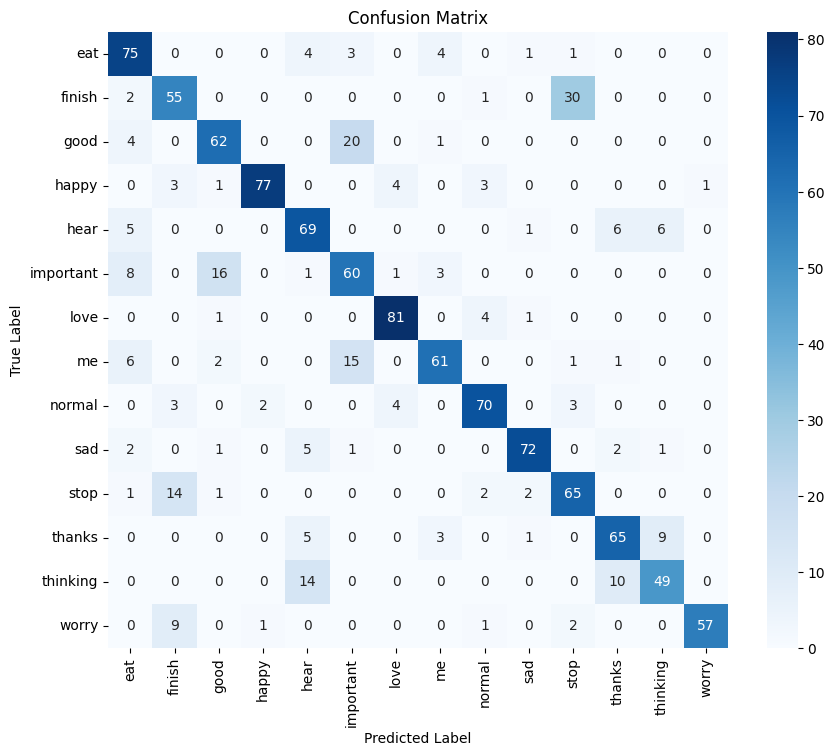

In [15]:
# Make predictions on the validation set
y30_pred_prob = LSTM_30_model.predict(X30_test)

# Convert predicted probabilities to class labels
y30_pred = np.argmax(y30_pred_prob, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y30_test, y30_pred)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [16]:
# Evaluate the model on the test data
evaluation = LSTM_30_model.evaluate(X30_test, y30_test)
accuracy = evaluation[1]

print("Accuracy:", accuracy)

37/37 [==============================] - 1s 26ms/step - loss: 0.5735 - accuracy: 0.7793
Accuracy: 0.7792869210243225


## Model 2: LSTM with Masking Layer sequence-length 30 [1]

In [18]:
LSTM_30Masking_model = Sequential()
LSTM_30Masking_model.add(Masking(mask_value=0., input_shape=(30, X30_train.shape[2])))
LSTM_30Masking_model.add(LSTM(64, return_sequences=True, activation='relu'))
LSTM_30Masking_model.add(LSTM(128, return_sequences=True, activation='relu'))
LSTM_30Masking_model.add(LSTM(64, return_sequences=False, activation='relu'))
LSTM_30Masking_model.add(Dense(64, activation='relu'))
LSTM_30Masking_model.add(Dense(32, activation='relu'))
LSTM_30Masking_model.add(Dense(14, activation='softmax')) # 14 classes

LSTM_30Masking_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

LSTM_30Masking_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 30, 258)           0         
                                                                 
 lstm_3 (LSTM)               (None, 30, 64)            82688     
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 14)               

### Training

In [21]:
model_save_path = 'LSTM_30Masking_model.h5' 

checkpoint_callback = ModelCheckpoint('LSTM_30Masking_model_checkpoint.h5', save_best_only=True)
early_stopping_callback = EarlyStopping(patience=10, restore_best_weights=True)
log_dir = os.path.join('Logs_LSTM_30Masking')
tb_callback = TensorBoard(log_dir=log_dir)

# Train the model with callbacks
LSTM_30Masking_model.fit(X30_train, y30_train, validation_data=(X30_test, y30_test), epochs=70, batch_size=32,
          callbacks=[checkpoint_callback, early_stopping_callback, tb_callback])

# Save the trained model
LSTM_30Masking_model.save(model_save_path)

Epoch 1/70
148/148 [==============================] - 16s 97ms/step - loss: 0.2373 - accuracy: 0.9112 - val_loss: 0.3670 - val_accuracy: 0.8820
Epoch 2/70
148/148 [==============================] - 11s 72ms/step - loss: 0.3047 - accuracy: 0.8917 - val_loss: 0.3629 - val_accuracy: 0.8913
Epoch 3/70
148/148 [==============================] - 13s 90ms/step - loss: 0.2223 - accuracy: 0.9178 - val_loss: 0.4529 - val_accuracy: 0.8514
Epoch 4/70
148/148 [==============================] - 13s 90ms/step - loss: 0.2408 - accuracy: 0.9165 - val_loss: 0.3813 - val_accuracy: 0.8744
Epoch 5/70
148/148 [==============================] - 14s 94ms/step - loss: 0.2271 - accuracy: 0.9180 - val_loss: 0.3970 - val_accuracy: 0.8769
Epoch 6/70
148/148 [==============================] - 14s 94ms/step - loss: 0.2535 - accuracy: 0.9085 - val_loss: 0.4094 - val_accuracy: 0.8803
Epoch 7/70
148/148 [==============================] - 14s 92ms/step - loss: 0.2265 - accuracy: 0.9229 - val_loss: 0.3629 - val_accuracy:

### Evaluation

37/37 [==============================] - 1s 28ms/step


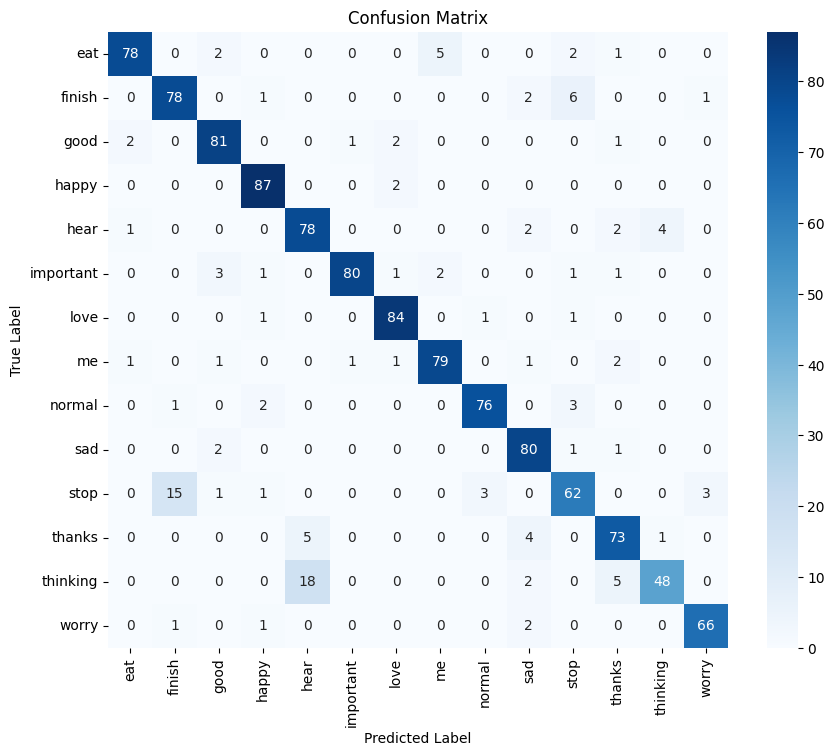

In [23]:
# Make predictions on the validation set
y30_pred_prob = LSTM_30Masking_model.predict(X30_test)

# Convert predicted probabilities to class labels
y30_pred = np.argmax(y30_pred_prob, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y30_test, y30_pred)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Evaluate the model on the test data
evaluation = LSTM_30Masking_model.evaluate(X30_test, y30_test)
accuracy = evaluation[1]
accuracy_percentage = accuracy * 100
print("Accuracy:", accuracy_percentage, "%")

37/37 [==============================] - 1s 30ms/step - loss: 0.3629 - accuracy: 0.8913
Accuracy: 89.13412690162659 %


## Model 3: LSTM with Masking Layer sequence-length 60

In [18]:
LSTM_60Masking_model = Sequential()
LSTM_60Masking_model.add(Masking(mask_value=0., input_shape=(60, 258)))
LSTM_60Masking_model.add(LSTM(64, return_sequences=True, activation='relu'))
LSTM_60Masking_model.add(LSTM(128, return_sequences=True, activation='relu'))
LSTM_60Masking_model.add(LSTM(64, return_sequences=False, activation='relu'))
LSTM_60Masking_model.add(Dense(64, activation='relu'))
LSTM_60Masking_model.add(Dense(32, activation='relu'))
LSTM_60Masking_model.add(Dense(14, activation='softmax')) # 14 classes

LSTM_60Masking_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

LSTM_60Masking_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, 60, 258)           0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 64)            82688     
                                                                 
 lstm_7 (LSTM)               (None, 60, 128)           98816     
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 14)               

### Training

In [19]:
model_save_path = 'LSTM_60Masking_model.h5' 

checkpoint_callback = ModelCheckpoint('LSTM_60Masking_model_checkpoint.h5', save_best_only=True)
early_stopping_callback = EarlyStopping(patience=10, restore_best_weights=True)
log_dir = os.path.join('Logs_LSTM_60Masking')
tb_callback = TensorBoard(log_dir=log_dir)

# Train the model with callbacks
LSTM_60Masking_model.fit(X60_train, y60_train, validation_data=(X60_test, y60_test), epochs=70, batch_size=32,
          callbacks=[checkpoint_callback, early_stopping_callback, tb_callback])

# Save the trained model
LSTM_60Masking_model.save(model_save_path)

Epoch 1/70
148/148 [==============================] - 33s 161ms/step - loss: 2.6601 - accuracy: 0.0892 - val_loss: 2.6214 - val_accuracy: 0.1188
Epoch 2/70
148/148 [==============================] - 25s 167ms/step - loss: 2.2274 - accuracy: 0.1907 - val_loss: 1.7187 - val_accuracy: 0.3277
Epoch 3/70
148/148 [==============================] - 19s 127ms/step - loss: 1.5111 - accuracy: 0.3880 - val_loss: 1.2980 - val_accuracy: 0.4542
Epoch 4/70
148/148 [==============================] - 21s 142ms/step - loss: 2.8458 - accuracy: 0.2703 - val_loss: 3.0292 - val_accuracy: 0.0679
Epoch 5/70
148/148 [==============================] - 24s 160ms/step - loss: 3.0434 - accuracy: 0.0828 - val_loss: 2.6361 - val_accuracy: 0.0874
Epoch 6/70
148/148 [==============================] - 22s 148ms/step - loss: 2.6315 - accuracy: 0.0886 - val_loss: 2.6290 - val_accuracy: 0.0883
Epoch 7/70
148/148 [==============================] - 23s 159ms/step - loss: 2.6135 - accuracy: 0.0977 - val_loss: 2.6017 - val_ac

### Evaluation

37/37 [==============================] - 2s 29ms/step


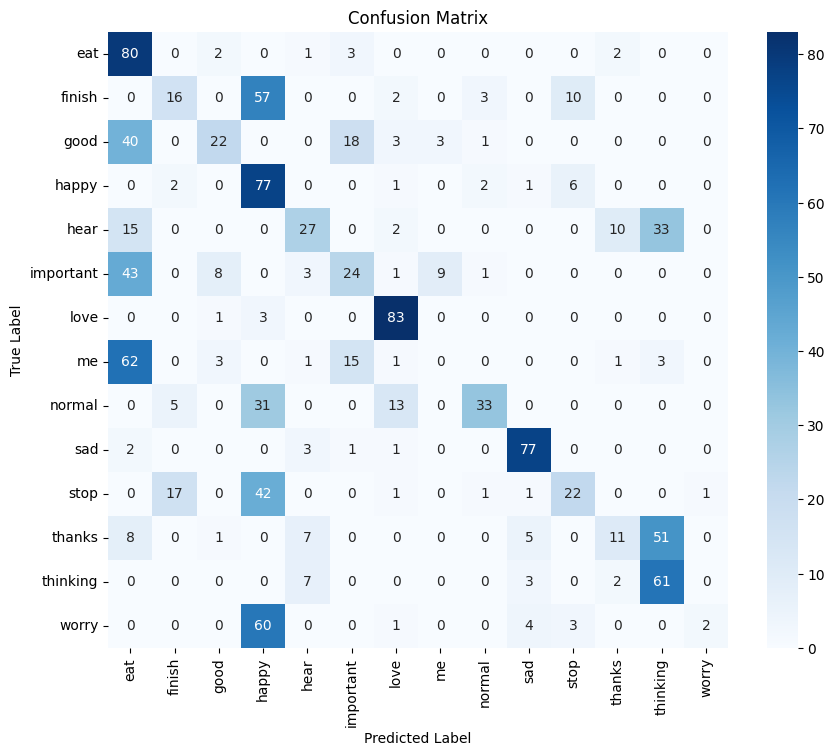

In [20]:
# Make predictions on the validation set
y60_pred_prob = LSTM_60Masking_model.predict(X60_test)

# Convert predicted probabilities to class labels
y60_pred = np.argmax(y60_pred_prob, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y60_test, y60_pred)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Evaluate the model on the test data
evaluation = LSTM_60Masking_model.evaluate(X60_test, y60_test)
accuracy = evaluation[1]
accuracy_percentage = accuracy * 100
print("Accuracy:", accuracy_percentage, "%")

37/37 [==============================] - 1s 29ms/step - loss: 1.2980 - accuracy: 0.4542
Accuracy: 45.415958762168884 %


## Model 4: LSTM with Masking Layer sequence-length 40 [2]

In [42]:
LSTM_40Masking_model = Sequential()
LSTM_40Masking_model.add(Masking(mask_value=0., input_shape=(40, 258)))
LSTM_40Masking_model.add(LSTM(64, return_sequences=True, activation='relu'))
LSTM_40Masking_model.add(LSTM(128, return_sequences=True, activation='relu'))
LSTM_40Masking_model.add(LSTM(64, return_sequences=False, activation='relu'))
LSTM_40Masking_model.add(Dense(64, activation='relu'))
LSTM_40Masking_model.add(Dense(32, activation='relu'))
LSTM_40Masking_model.add(Dense(14, activation='softmax')) # 14 classes

LSTM_40Masking_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

LSTM_40Masking_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, 40, 258)           0         
                                                                 
 lstm_9 (LSTM)               (None, 40, 64)            82688     
                                                                 
 lstm_10 (LSTM)              (None, 40, 128)           98816     
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 14)               

### Training

In [44]:
model_save_path = 'LSTM_40Masking_model.h5' 

checkpoint_callback = ModelCheckpoint('LSTM_40Masking_model_checkpoint.h5', save_best_only=True)
early_stopping_callback = EarlyStopping(patience=10, restore_best_weights=True)
log_dir = os.path.join('Logs_LSTM_40Masking')
tb_callback = TensorBoard(log_dir=log_dir)

# Train the model with callbacks
LSTM_40Masking_model.fit(X40_train, y40_train, validation_data=(X40_test, y40_test), epochs=60, batch_size=32,
          callbacks=[checkpoint_callback, early_stopping_callback, tb_callback])

# Save the trained model
LSTM_40Masking_model.save(model_save_path)

Epoch 1/60
148/148 [==============================] - 20s 124ms/step - loss: 0.1059 - accuracy: 0.9639 - val_loss: 0.2393 - val_accuracy: 0.9228
Epoch 2/60
148/148 [==============================] - 18s 125ms/step - loss: 0.0899 - accuracy: 0.9715 - val_loss: 0.2433 - val_accuracy: 0.9211
Epoch 3/60
148/148 [==============================] - 17s 117ms/step - loss: 0.0815 - accuracy: 0.9747 - val_loss: 0.2589 - val_accuracy: 0.9211
Epoch 4/60
148/148 [==============================] - 18s 124ms/step - loss: 0.0762 - accuracy: 0.9730 - val_loss: 0.2665 - val_accuracy: 0.9202
Epoch 5/60
148/148 [==============================] - 18s 122ms/step - loss: 0.0809 - accuracy: 0.9735 - val_loss: 0.2709 - val_accuracy: 0.9177
Epoch 6/60
148/148 [==============================] - 18s 122ms/step - loss: 0.0742 - accuracy: 0.9730 - val_loss: 0.2719 - val_accuracy: 0.9304
Epoch 7/60
148/148 [==============================] - 18s 125ms/step - loss: 0.0646 - accuracy: 0.9769 - val_loss: 0.2841 - val_ac

### Evaluation

37/37 [==============================] - 2s 31ms/step


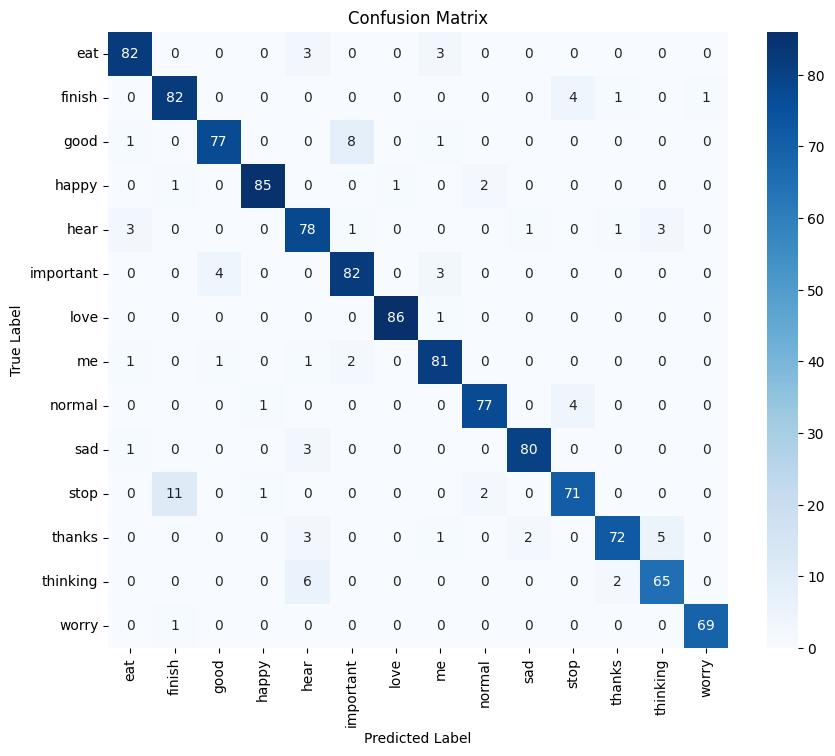

In [45]:
# Make predictions on the validation set
y40_pred_prob = LSTM_40Masking_model.predict(X40_test)

# Convert predicted probabilities to class labels
y40_pred = np.argmax(y40_pred_prob, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y40_test, y40_pred)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [46]:
# Evaluate the model on the test data
evaluation = LSTM_40Masking_model.evaluate(X40_test, y40_test)
accuracy = evaluation[1]
accuracy_percentage = accuracy * 100
print("Accuracy:", accuracy_percentage, "%")

37/37 [==============================] - 1s 31ms/step - loss: 0.2393 - accuracy: 0.9228
Accuracy: 92.27504134178162 %


## Model 5: LSTM with Masking Layer sequence-length 50

In [44]:
LSTM_50Masking_model = Sequential()
LSTM_50Masking_model.add(Masking(mask_value=0., input_shape=(50, 258)))
LSTM_50Masking_model.add(LSTM(64, return_sequences=True, activation='relu'))
LSTM_50Masking_model.add(LSTM(128, return_sequences=True, activation='relu'))
LSTM_50Masking_model.add(LSTM(64, return_sequences=False, activation='relu'))
LSTM_50Masking_model.add(Dense(64, activation='relu'))
LSTM_50Masking_model.add(Dense(32, activation='relu'))
LSTM_50Masking_model.add(Dense(14, activation='softmax')) # 14 classes

LSTM_50Masking_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

LSTM_50Masking_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_8 (Masking)         (None, 50, 258)           0         
                                                                 
 lstm_24 (LSTM)              (None, 50, 64)            82688     
                                                                 
 lstm_25 (LSTM)              (None, 50, 128)           98816     
                                                                 
 lstm_26 (LSTM)              (None, 64)                49408     
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 14)               

### Training

In [45]:
model_save_path = 'LSTM_50Masking_model.h5' 

checkpoint_callback = ModelCheckpoint('LSTM_50Masking_model_checkpoint.h5', save_best_only=True)
early_stopping_callback = EarlyStopping(patience=10, restore_best_weights=True)
log_dir = os.path.join('Logs_LSTM_50Masking')
tb_callback = TensorBoard(log_dir=log_dir)

# Train the model with callbacks
LSTM_50Masking_model.fit(X50_train, y50_train, validation_data=(X50_test, y50_test), epochs=60, batch_size=32,
          callbacks=[checkpoint_callback, early_stopping_callback, tb_callback])

# Save the trained model
LSTM_50Masking_model.save(model_save_path)

Epoch 1/60
148/148 [==============================] - 30s 140ms/step - loss: 2.8547 - accuracy: 0.1391 - val_loss: 2.2985 - val_accuracy: 0.1740
Epoch 2/60
148/148 [==============================] - 16s 106ms/step - loss: 1.8670 - accuracy: 0.2975 - val_loss: 1.7784 - val_accuracy: 0.3438
Epoch 3/60
148/148 [==============================] - 19s 129ms/step - loss: 1.5464 - accuracy: 0.4092 - val_loss: 1.3893 - val_accuracy: 0.4762
Epoch 4/60
148/148 [==============================] - 12s 83ms/step - loss: 1.6994 - accuracy: 0.3755 - val_loss: 1.3884 - val_accuracy: 0.4236
Epoch 5/60
148/148 [==============================] - 14s 92ms/step - loss: 1.3369 - accuracy: 0.4872 - val_loss: 1.1985 - val_accuracy: 0.5119
Epoch 6/60
148/148 [==============================] - 20s 134ms/step - loss: 1.0998 - accuracy: 0.5740 - val_loss: 1.2015 - val_accuracy: 0.5187
Epoch 7/60
148/148 [==============================] - 16s 110ms/step - loss: 1.0700 - accuracy: 0.5850 - val_loss: 0.9861 - val_accu

### Evaluation

37/37 [==============================] - 2s 21ms/step


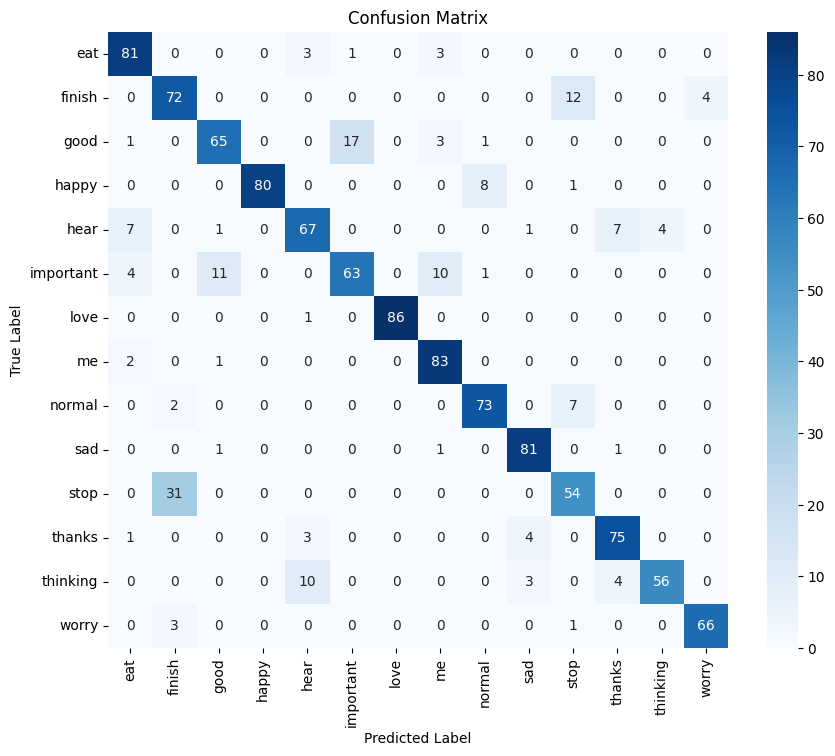

In [46]:
# Make predictions on the validation set
y50_pred_prob = LSTM_50Masking_model.predict(X50_test)

# Convert predicted probabilities to class labels
y50_pred = np.argmax(y50_pred_prob, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y50_test, y50_pred)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [47]:
# Evaluate the model on the test data
evaluation = LSTM_50Masking_model.evaluate(X50_test, y50_test)
accuracy = evaluation[1]
accuracy_percentage = accuracy * 100
print("Accuracy:", accuracy_percentage, "%")

37/37 [==============================] - 1s 24ms/step - loss: 0.3979 - accuracy: 0.8506
Accuracy: 85.05942225456238 %


## Model 6: LSTM with Masking Layer sequence-length 45

In [27]:
LSTM_45Masking_model = Sequential()
LSTM_45Masking_model.add(Masking(mask_value=0., input_shape=(45, 258)))
LSTM_45Masking_model.add(LSTM(64, return_sequences=True, activation='relu'))
LSTM_45Masking_model.add(LSTM(128, return_sequences=True, activation='relu'))
LSTM_45Masking_model.add(LSTM(64, return_sequences=False, activation='relu'))
LSTM_45Masking_model.add(Dense(64, activation='relu'))
LSTM_45Masking_model.add(Dense(32, activation='relu'))
LSTM_45Masking_model.add(Dense(14, activation='softmax')) # 14 classes

LSTM_45Masking_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

LSTM_45Masking_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_4 (Masking)         (None, 45, 258)           0         
                                                                 
 lstm_12 (LSTM)              (None, 45, 64)            82688     
                                                                 
 lstm_13 (LSTM)              (None, 45, 128)           98816     
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 14)               

### Training

In [28]:
model_save_path = 'LSTM_45Masking_model.h5' 

checkpoint_callback = ModelCheckpoint('LSTM_45Masking_model_checkpoint.h5', save_best_only=True)
early_stopping_callback = EarlyStopping(patience=10, restore_best_weights=True)
log_dir = os.path.join('Logs_LSTM_45Masking')
tb_callback = TensorBoard(log_dir=log_dir)

# Train the model with callbacks
LSTM_45Masking_model.fit(X45_train, y45_train, validation_data=(X45_test, y45_test), epochs=60, batch_size=32,
          callbacks=[checkpoint_callback, early_stopping_callback, tb_callback])

# Save the trained model
LSTM_45Masking_model.save(model_save_path)

Epoch 1/60
148/148 [==============================] - ETA: 0s - loss: 2.2528 - accuracy: 0.1805

D:\GUC\Semester 8 - Bachelor\DL Projects\Word-Level SLR\wordRecognitionEnv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


148/148 [==============================] - 26s 114ms/step - loss: 2.2528 - accuracy: 0.1805 - val_loss: 1.9715 - val_accuracy: 0.1986
Epoch 2/60
148/148 [==============================] - 15s 99ms/step - loss: 2.2489 - accuracy: 0.1947 - val_loss: 1.9115 - val_accuracy: 0.2139
Epoch 3/60
148/148 [==============================] - 14s 92ms/step - loss: 1.7317 - accuracy: 0.3011 - val_loss: 1.8199 - val_accuracy: 0.2538
Epoch 4/60
148/148 [==============================] - 15s 102ms/step - loss: 1.4773 - accuracy: 0.3980 - val_loss: 1.3946 - val_accuracy: 0.4075
Epoch 5/60
148/148 [==============================] - 14s 96ms/step - loss: 1.3133 - accuracy: 0.4595 - val_loss: 1.8949 - val_accuracy: 0.3455
Epoch 6/60
148/148 [==============================] - 15s 103ms/step - loss: 1.2289 - accuracy: 0.5003 - val_loss: 1.2628 - val_accuracy: 0.4813
Epoch 7/60
148/148 [==============================] - 14s 94ms/step - loss: 1.0094 - accuracy: 0.5891 - val_loss: 1.0362 - val_accuracy: 0.6087


### Evaluation

37/37 [==============================] - 2s 29ms/step


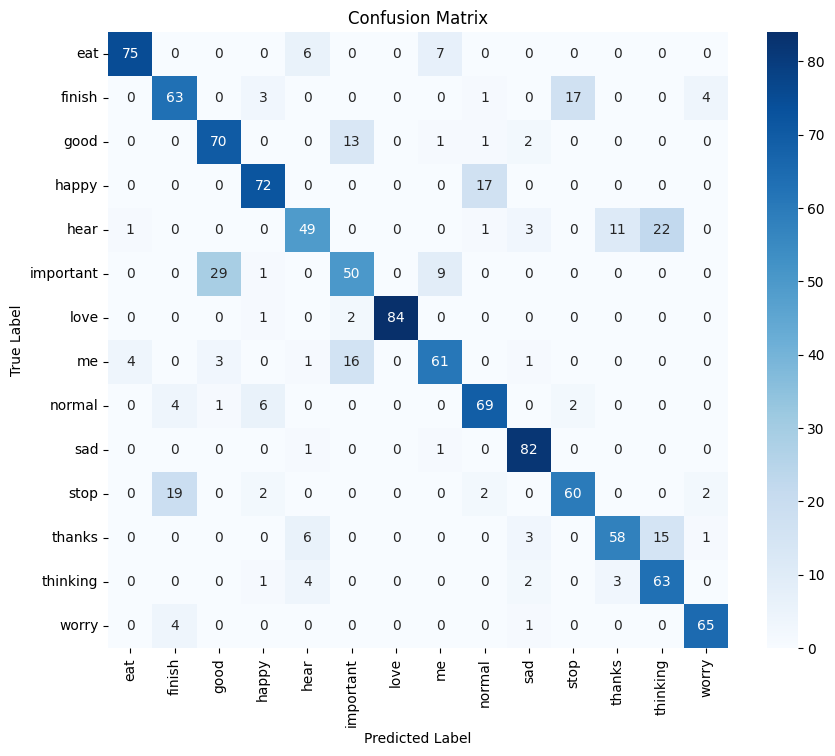

In [29]:
# Make predictions on the validation set
y45_pred_prob = LSTM_45Masking_model.predict(X45_test)

# Convert predicted probabilities to class labels
y45_pred = np.argmax(y45_pred_prob, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y45_test, y45_pred)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [30]:
# Evaluate the model on the test data
evaluation = LSTM_45Masking_model.evaluate(X45_test, y45_test)
accuracy = evaluation[1]
accuracy_percentage = accuracy * 100
print("Accuracy:", accuracy_percentage, "%")

37/37 [==============================] - 1s 27ms/step - loss: 0.5967 - accuracy: 0.7818
Accuracy: 78.18335890769958 %


## Model 7: LSTM with Masking Layer sequence-length 35

In [65]:
LSTM_35Masking_model = Sequential()
LSTM_35Masking_model.add(Masking(mask_value=0., input_shape=(35, 258)))
LSTM_35Masking_model.add(LSTM(64, return_sequences=True, activation='relu'))
LSTM_35Masking_model.add(LSTM(128, return_sequences=True, activation='relu'))
LSTM_35Masking_model.add(LSTM(64, return_sequences=False, activation='relu'))
LSTM_35Masking_model.add(Dense(64, activation='relu'))
LSTM_35Masking_model.add(Dense(32, activation='relu'))
LSTM_35Masking_model.add(Dense(14, activation='softmax')) # 14 classes

LSTM_35Masking_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

LSTM_35Masking_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_9 (Masking)         (None, 35, 258)           0         
                                                                 
 lstm_27 (LSTM)              (None, 35, 64)            82688     
                                                                 
 lstm_28 (LSTM)              (None, 35, 128)           98816     
                                                                 
 lstm_29 (LSTM)              (None, 64)                49408     
                                                                 
 dense_27 (Dense)            (None, 64)                4160      
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 14)               

### Training

In [66]:
model_save_path = 'LSTM_35Masking_model.h5' 

checkpoint_callback = ModelCheckpoint('LSTM_35Masking_model_checkpoint.h5', save_best_only=True)
early_stopping_callback = EarlyStopping(patience=10, restore_best_weights=True)
log_dir = os.path.join('Logs_LSTM_35Masking')
tb_callback = TensorBoard(log_dir=log_dir)

# Train the model with callbacks
LSTM_35Masking_model.fit(X35_train, y35_train, validation_data=(X35_test, y35_test), epochs=60, batch_size=32,
          callbacks=[checkpoint_callback, early_stopping_callback, tb_callback])

# Save the trained model
LSTM_35Masking_model.save(model_save_path)

Epoch 1/60
148/148 [==============================] - 24s 84ms/step - loss: 2.3241 - accuracy: 0.1629 - val_loss: 2.2858 - val_accuracy: 0.1392
Epoch 2/60


D:\GUC\Semester 8 - Bachelor\DL Projects\Word-Level SLR\wordRecognitionEnv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


148/148 [==============================] - 13s 90ms/step - loss: 1.9503 - accuracy: 0.2553 - val_loss: 1.7640 - val_accuracy: 0.2954
Epoch 3/60
148/148 [==============================] - 15s 100ms/step - loss: 1.6529 - accuracy: 0.3298 - val_loss: 1.8777 - val_accuracy: 0.2716
Epoch 4/60
148/148 [==============================] - 15s 101ms/step - loss: 1.5407 - accuracy: 0.3931 - val_loss: 1.4636 - val_accuracy: 0.4516
Epoch 5/60
148/148 [==============================] - 14s 98ms/step - loss: 1.2610 - accuracy: 0.4933 - val_loss: 1.3315 - val_accuracy: 0.4762
Epoch 6/60
148/148 [==============================] - 12s 82ms/step - loss: 1.1562 - accuracy: 0.5343 - val_loss: 1.1005 - val_accuracy: 0.5314
Epoch 7/60
148/148 [==============================] - 14s 97ms/step - loss: 1.0880 - accuracy: 0.5511 - val_loss: 1.0202 - val_accuracy: 0.5959
Epoch 8/60
148/148 [==============================] - 14s 95ms/step - loss: 1.1136 - accuracy: 0.5708 - val_loss: 1.1695 - val_accuracy: 0.5229
E

### Evaluation

37/37 [==============================] - 2s 17ms/step


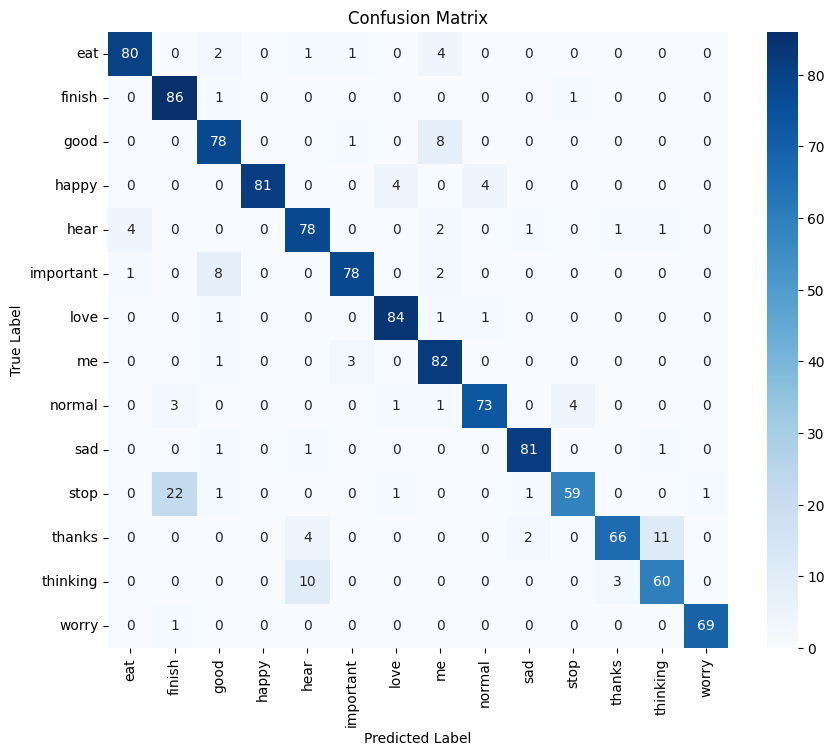

In [67]:
# Make predictions on the validation set
y35_pred_prob = LSTM_35Masking_model.predict(X35_test)

# Convert predicted probabilities to class labels
y35_pred = np.argmax(y35_pred_prob, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y35_test, y35_pred)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [68]:
# Evaluate the model on the test data
evaluation = LSTM_35Masking_model.evaluate(X35_test, y35_test)
accuracy = evaluation[1]
accuracy_percentage = accuracy * 100
print("Accuracy:", accuracy_percentage, "%")

37/37 [==============================] - 1s 16ms/step - loss: 0.3292 - accuracy: 0.8956
Accuracy: 89.55857157707214 %


## Model 8: LSTM with Masking Layer sequence-length 20

In [72]:
LSTM_20Masking_model = Sequential()
LSTM_20Masking_model.add(Masking(mask_value=0., input_shape=(20, 258)))
LSTM_20Masking_model.add(LSTM(64, return_sequences=True, activation='relu'))
LSTM_20Masking_model.add(LSTM(128, return_sequences=True, activation='relu'))
LSTM_20Masking_model.add(LSTM(64, return_sequences=False, activation='relu'))
LSTM_20Masking_model.add(Dense(64, activation='relu'))
LSTM_20Masking_model.add(Dense(32, activation='relu'))
LSTM_20Masking_model.add(Dense(14, activation='softmax')) # 14 classes

LSTM_20Masking_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

LSTM_20Masking_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_10 (Masking)        (None, 20, 258)           0         
                                                                 
 lstm_30 (LSTM)              (None, 20, 64)            82688     
                                                                 
 lstm_31 (LSTM)              (None, 20, 128)           98816     
                                                                 
 lstm_32 (LSTM)              (None, 64)                49408     
                                                                 
 dense_30 (Dense)            (None, 64)                4160      
                                                                 
 dense_31 (Dense)            (None, 32)                2080      
                                                                 
 dense_32 (Dense)            (None, 14)              

### Training

In [74]:
model_save_path = 'LSTM_20Masking_model.h5' 

checkpoint_callback = ModelCheckpoint('LSTM_20Masking_model_checkpoint.h5', save_best_only=True)
early_stopping_callback = EarlyStopping(patience=10, restore_best_weights=True)
log_dir = os.path.join('Logs_LSTM_20Masking')
tb_callback = TensorBoard(log_dir=log_dir)

# Train the model with callbacks
LSTM_20Masking_model.fit(X20_train, y20_train, validation_data=(X20_test, y20_test), epochs=60, batch_size=32,
          callbacks=[checkpoint_callback, early_stopping_callback, tb_callback])

# Save the trained model
LSTM_20Masking_model.save(model_save_path)

Epoch 1/60
148/148 [==============================] - 20s 66ms/step - loss: 2.4881 - accuracy: 0.1266 - val_loss: 2.1489 - val_accuracy: 0.2284
Epoch 2/60


D:\GUC\Semester 8 - Bachelor\DL Projects\Word-Level SLR\wordRecognitionEnv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


148/148 [==============================] - 8s 53ms/step - loss: 2.1033 - accuracy: 0.2155 - val_loss: 1.9540 - val_accuracy: 0.2725
Epoch 3/60
148/148 [==============================] - 8s 54ms/step - loss: 1.9701 - accuracy: 0.2536 - val_loss: 2.0342 - val_accuracy: 0.2470
Epoch 4/60
148/148 [==============================] - 9s 58ms/step - loss: 1.8500 - accuracy: 0.2935 - val_loss: 1.7729 - val_accuracy: 0.3098
Epoch 5/60
148/148 [==============================] - 9s 60ms/step - loss: 1.7246 - accuracy: 0.3321 - val_loss: 1.6834 - val_accuracy: 0.3659
Epoch 6/60
148/148 [==============================] - 9s 64ms/step - loss: 1.6448 - accuracy: 0.3504 - val_loss: 1.6965 - val_accuracy: 0.3582
Epoch 7/60
148/148 [==============================] - 9s 58ms/step - loss: 1.5590 - accuracy: 0.3839 - val_loss: 1.5730 - val_accuracy: 0.3922
Epoch 8/60
148/148 [==============================] - 9s 58ms/step - loss: 1.4972 - accuracy: 0.4065 - val_loss: 1.5391 - val_accuracy: 0.3650
Epoch 9/60

### Evaluation

37/37 [==============================] - 1s 10ms/step


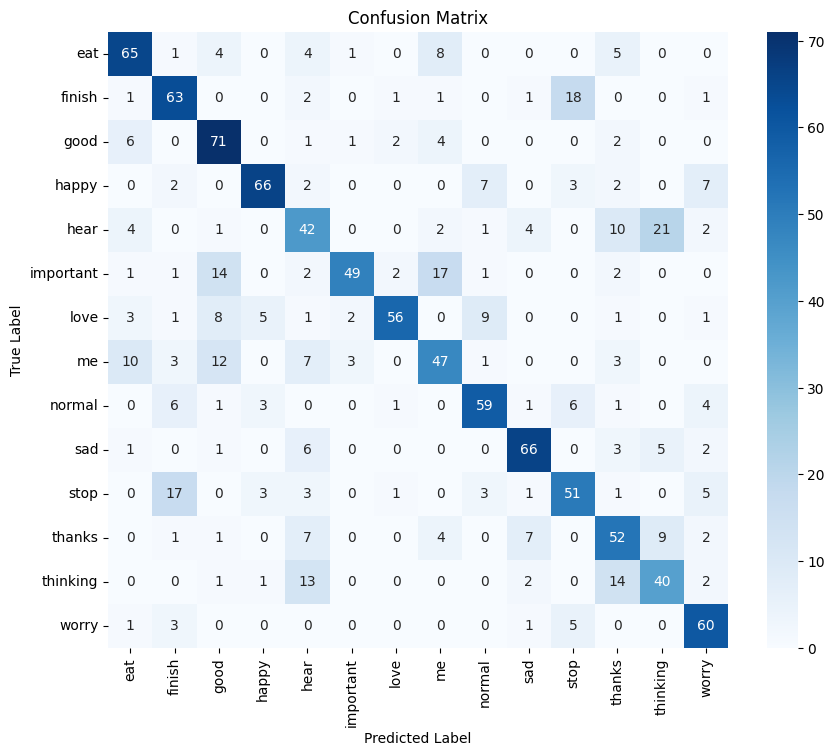

In [75]:
# Make predictions on the validation set
y20_pred_prob = LSTM_20Masking_model.predict(X20_test)

# Convert predicted probabilities to class labels
y20_pred = np.argmax(y20_pred_prob, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y20_test, y20_pred)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [76]:
# Evaluate the model on the test data
evaluation = LSTM_20Masking_model.evaluate(X20_test, y20_test)
accuracy = evaluation[1]
accuracy_percentage = accuracy * 100
print("Accuracy:", accuracy_percentage, "%")

37/37 [==============================] - 1s 12ms/step - loss: 0.9762 - accuracy: 0.6681
Accuracy: 66.8081521987915 %


# Testing Real-Time (Word Recognition)

In [12]:
label_encoder = LabelEncoder()
# Fit label encoder and transform labels to integers
y_30_encoded = label_encoder.fit_transform(labels_30)

# Get the unique classes (words) and their corresponding encoded indices
word_indices = {index: word for index, word in enumerate(label_encoder.classes_)}

print("Index to Word Mapping:")
for index, word in word_indices.items():
    print(f"Index: {index}, Word: {word}")

Index to Word Mapping:
Index: 0, Word: eat
Index: 1, Word: finish
Index: 2, Word: good
Index: 3, Word: happy
Index: 4, Word: hear
Index: 5, Word: important
Index: 6, Word: love
Index: 7, Word: me
Index: 8, Word: normal
Index: 9, Word: sad
Index: 10, Word: stop
Index: 11, Word: thanks
Index: 12, Word: thinking
Index: 13, Word: worry


In [13]:
english_to_arabic = {
    "eat": "يأكل",
    "finish": "ينهي", 
    "good": "جيد", 
    "happy":"سعيد", 
    "hear": "يسمع",
    "important": "مهم",
    "love": "يحب",
    "me": "أنا",
    "normal": "عادي",
    "sad": "حزين", 
    "stop": "توقف", 
    "thanks": "شكرا ",
    "thinking": "يفكر",
    "worry": "قلق",
}

def convert_to_arabic(english_word):
    return english_to_arabic.get(english_word, english_word)


## Load Trained Models

In [14]:
loaded_30_model = load_model('LSTM_30Masking_model.h5')

In [15]:
loaded_40_model = load_model('LSTM_40Masking_model.h5')

In [16]:
loaded_50_model = load_model('LSTM_50Masking_model.h5')

In [17]:
loaded_20_model = load_model('LSTM_20Masking_model.h5')

In [18]:
loaded_35_model = load_model('LSTM_35Masking_model.h5')

## Trying it out

### Test1: only 1 LSTM Model (fixed-length)

#### Fixed-length 30

In [20]:
# 1. New detection variables
sequence = []
sentence = []
#predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)  # Extract keypoints from results
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = loaded_30_model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_index = np.argmax(res)
            
            # Map predicted index to word using the index-to-word mapping dictionary
            predicted_word = word_indices.get(predicted_index, "Unknown")

            confidence_percentage = res[predicted_index] * 100
            
            #predictions.append(predicted_index)
        
            # Output currently predicted word in Arabic
            arabic_equivalent = convert_to_arabic(predicted_word)
            reshaped_text = arabic_reshaper.reshape(arabic_equivalent)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
            
            
            #english_text = f"English: {predicted_word}"
            confidence_text = f"Confidence: {confidence_percentage:.2f}%"
            #draw.text((50, 50), english_text, font=font,fill="black")
            draw.text((50, 50), bidi_text, font=font,fill="black")
            draw.text((50, 80), confidence_text, font=font,fill="black")
            image = np.array(img_pil)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

#### Fixed-length 50

In [32]:
# 1. New detection variables
sequence = []
sentence = []
#predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)  # Extract keypoints from results
        sequence.append(keypoints)
        sequence = sequence[-50:]
        
        if len(sequence) == 50:
            res = loaded_50_model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_index = np.argmax(res)
            
            # Map predicted index to word using the index-to-word mapping dictionary
            predicted_word = word_indices.get(predicted_index, "Unknown")

            confidence_percentage = res[predicted_index] * 100
            
            #predictions.append(predicted_index)
        
            # Output currently predicted word in Arabic
            arabic_equivalent = convert_to_arabic(predicted_word)
            reshaped_text = arabic_reshaper.reshape(arabic_equivalent)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
            
            
            #english_text = f"English: {predicted_word}"
            confidence_text = f"Confidence: {confidence_percentage:.2f}%"
            #draw.text((50, 50), english_text, font=font,fill="black")
            draw.text((50, 50), bidi_text, font=font,fill="black")
            draw.text((50, 80), confidence_text, font=font,fill="black")
            image = np.array(img_pil)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

#### Fixed-length 20

In [78]:
# 1. New detection variables
sequence = []
sentence = []
#predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)  # Extract keypoints from results
        sequence.append(keypoints)
        sequence = sequence[-20:]
        
        if len(sequence) == 20:
            res = loaded_20_model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_index = np.argmax(res)
            
            # Map predicted index to word using the index-to-word mapping dictionary
            predicted_word = word_indices.get(predicted_index, "Unknown")

            confidence_percentage = res[predicted_index] * 100
            
            #predictions.append(predicted_index)
        
            # Output currently predicted word in Arabic
            arabic_equivalent = convert_to_arabic(predicted_word)
            reshaped_text = arabic_reshaper.reshape(arabic_equivalent)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
            
            
            #english_text = f"English: {predicted_word}"
            confidence_text = f"Confidence: {confidence_percentage:.2f}%"
            #draw.text((50, 50), english_text, font=font,fill="black")
            draw.text((50, 50), bidi_text, font=font,fill="black")
            draw.text((50, 80), confidence_text, font=font,fill="black")
            image = np.array(img_pil)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

### Test2: Two-LSTM Models (lengths 30 & 40) - simple comparison no handling of unused frames

In [46]:
# 1. New detection variables
sequence = []
sentence = []
#predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)  # Extract keypoints from results
        sequence.append(keypoints)
        sequence = sequence[-40:] #Use 40 frames
        
        if len(sequence) == 40:
            res_30 = loaded_30_model.predict(np.expand_dims(sequence[-30:], axis=0))[0]
            res_40 = loaded_40_model.predict(np.expand_dims(sequence, axis=0))[0]
            
            predicted_index_30 = np.argmax(res_30)
            predicted_index_40 = np.argmax(res_40)
            
            # Map predicted index to word using the index-to-word mapping dictionary
            predicted_word_30 = word_indices.get(predicted_index_30, "Unknown")
            predicted_word_40 = word_indices.get(predicted_index_40, "Unknown")

            confidence_percentage_30 = res_30[predicted_index_30] * 100
            confidence_percentage_40 = res_40[predicted_index_40] * 100

            if confidence_percentage_30 >= confidence_percentage_40:
                predicted_word = predicted_word_30
                confidence_percentage = confidence_percentage_30
                model_label = "Model 1 (30)"
            else:
                predicted_word = predicted_word_40
                confidence_percentage = confidence_percentage_40
                model_label = "Model 2 (40)"
            
            #predictions.append(predicted_index)
        
            # Output currently predicted word in Arabic
            arabic_equivalent = convert_to_arabic(predicted_word)
            reshaped_text = arabic_reshaper.reshape(arabic_equivalent)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
            
            
            #english_text = f"English: {predicted_word}"
            confidence_text = f"Confidence: {confidence_percentage:.2f}%"
            model_label_text = f"{model_label}"
            #draw.text((50, 50), english_text, font=font,fill="black")
            draw.text((50, 50), bidi_text, font=font,fill="black")
            draw.text((50, 80), confidence_text, font=font,fill="black")
            draw.text((50, 120), model_label_text, font=font,fill="black")
            image = np.array(img_pil)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>


### Test3: Two-LSTM Models (lengths 30 & 40) - handling unused frames

In [33]:
# Initialize variables
sequence = []  # Use list to keep track of frames
threshold = 0.5
confidence_30 =0.0
confidence_40 =0.0
model_label = ""


cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Add keypoints to the sequence
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        
        # Once the sequence reaches length 40
        if len(sequence) == 40:
            # Use the first 30 frames for model 1 and all 40 frames for model 2
            res_30 = loaded_30_model.predict(np.expand_dims(sequence[:30], axis=0))[0]
            res_40 = loaded_40_model.predict(np.expand_dims(sequence, axis=0))[0]
            
            # Get predicted indices and confidences
            predicted_index_30 = np.argmax(res_30)
            predicted_index_40 = np.argmax(res_40)
            confidence_30 = res_30[predicted_index_30]
            confidence_40 = res_40[predicted_index_40]
            
            # Choose the model with higher confidence
            if confidence_30 >= confidence_40:
                predicted_word = word_indices.get(predicted_index_30, "Unknown")
                unused_frames = sequence[30:]  # Unused frames for the next sequence
                model_label = "Model 1"
            else:
                predicted_word = word_indices.get(predicted_index_40, "Unknown")
                unused_frames = []  # No unused frames 
                model_label = "Model 2"
            
            # Reset the sequence to contain only unused frames
            sequence = unused_frames

        
        if predicted_word:
            # Output the prediction
            arabic_equivalent = convert_to_arabic(predicted_word)
            reshaped_text = arabic_reshaper.reshape(arabic_equivalent)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
                
            confidence_text = f"Confidence: {confidence_30 * 100:.2f}%" if confidence_30 >= confidence_40 else f"Confidence: {confidence_40 * 100:.2f}%"
            model_label_text = f"{model_label}"
            draw.text((50, 50), bidi_text, font=font, fill="black")
            draw.text((50, 80), confidence_text, font=font, fill="black")
            draw.text((50, 120), model_label_text, font=font, fill="black")           
            image = np.array(img_pil)
            
        
        # Show the output image
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 29ms/step


# Testing  Real-Time (Sentence Recognition)

## Model20

In [37]:
sequence = []
sentence = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)  # Extract keypoints from results
        sequence.append(keypoints)
        sequence = sequence[-20:]
        
        if len(sequence) == 20:
            res = loaded_20_model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_index = np.argmax(res)
            
            # Map predicted index to word using the index-to-word mapping dictionary
            predicted_word = word_indices.get(predicted_index, "Unknown")

            confidence_percentage = res[predicted_index] * 100
            
            #predictions.append(predicted_index)
        
            # Output currently predicted word in Arabic
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
            
            
            #english_text = f"English: {predicted_word}"
            confidence_text = f"Confidence: {confidence_percentage:.2f}%"
            #draw.text((50, 50), english_text, font=font,fill="black")
            draw.text((50, 50), bidi_text, font=font,fill="black")
            draw.text((50, 80), confidence_text, font=font,fill="black")
            image = np.array(img_pil)
        
        # Show to screen
        cv2.imshow('Model20', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

## Model30

In [30]:
# 1. New detection variables
sequence = []
sentence = []
#predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)  # Extract keypoints from results
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = loaded_30_model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_index = np.argmax(res)
            
            # Map predicted index to word using the index-to-word mapping dictionary
            predicted_word = word_indices.get(predicted_index, "Unknown")

            confidence_percentage = res[predicted_index] * 100
            
            #predictions.append(predicted_index)
        
            # Output currently predicted word in Arabic
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
            
            
            #english_text = f"English: {predicted_word}"
            confidence_text = f"Confidence: {confidence_percentage:.2f}%"
            #draw.text((50, 50), english_text, font=font,fill="black")
            draw.text((50, 50), bidi_text, font=font,fill="black")
            draw.text((50, 80), confidence_text, font=font,fill="black")
            image = np.array(img_pil)
        
        # Show to screen
        cv2.imshow('Model30', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

## Model40

In [31]:
sequence = []
sentence = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)  # Extract keypoints from results
        sequence.append(keypoints)
        sequence = sequence[-40:]
        
        if len(sequence) == 40:
            res = loaded_40_model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_index = np.argmax(res)
            
            # Map predicted index to word using the index-to-word mapping dictionary
            predicted_word = word_indices.get(predicted_index, "Unknown")

            confidence_percentage = res[predicted_index] * 100
            
            #predictions.append(predicted_index)
        
            # Output currently predicted word in Arabic
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
            
            
            #english_text = f"English: {predicted_word}"
            confidence_text = f"Confidence: {confidence_percentage:.2f}%"
            #draw.text((50, 50), english_text, font=font,fill="black")
            draw.text((50, 50), bidi_text, font=font,fill="black")
            draw.text((50, 80), confidence_text, font=font,fill="black")
            image = np.array(img_pil)
        
        # Show to screen
        cv2.imshow('Model40', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

## Model20+30

In [27]:
# Initialize variables
sequence = []  # Use list to keep track of frames
sentence = []
threshold = 0.5
confidence_20 =0.0
confidence_30 =0.0
model_label = ""
predicted_word=""


cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Add keypoints to the sequence
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        
        
        if len(sequence) == 30:
            res_20 = loaded_20_model.predict(np.expand_dims(sequence[:20], axis=0))[0]
            res_30 = loaded_30_model.predict(np.expand_dims(sequence, axis=0))[0]
            
            # Get predicted indices and confidences
            predicted_index_20 = np.argmax(res_20)
            predicted_index_30 = np.argmax(res_30)
            confidence_20 = res_20[predicted_index_20]
            confidence_30 = res_30[predicted_index_30]
            
            # Choose the model with higher confidence
            if confidence_20 >= confidence_30:
                predicted_word = word_indices.get(predicted_index_20, "Unknown")
                unused_frames = sequence[20:]  # Unused frames for the next sequence
                model_label = "Model 1: 20 frames"
            else:
                predicted_word = word_indices.get(predicted_index_30, "Unknown")
                unused_frames = []  # No unused frames 
                model_label = "Model 2: 30 frames"
            
            # Reset the sequence to contain only unused frames
            sequence = unused_frames
            
        if predicted_word:
            # Output the prediction
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
                
            confidence_text = f"Confidence: {confidence_20 * 100:.2f}%" if confidence_20 >= confidence_20 else f"Confidence: {confidence_30 * 100:.2f}%"
            model_label_text = f"{model_label}"
            draw.text((50, 50), bidi_text, font=font, fill="black")
            draw.text((50, 80), confidence_text, font=font, fill="black")
            draw.text((50, 120), model_label_text, font=font, fill="black")           
            image = np.array(img_pil)
            
        
        # Show the output image
        cv2.imshow('Model20+30', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 28ms/step


## Model30+40

In [34]:
# Initialize variables
sequence = []  # Use list to keep track of frames
sentence = []
threshold = 0.5
confidence_30 =0.0
confidence_40 =0.0
model_label = ""
predicted_word=""


cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Add keypoints to the sequence
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        
        # Once the sequence reaches length 40
        if len(sequence) == 40:
            # Use the first 30 frames for model 1 and all 40 frames for model 2
            res_30 = loaded_30_model.predict(np.expand_dims(sequence[:30], axis=0))[0]
            res_40 = loaded_40_model.predict(np.expand_dims(sequence, axis=0))[0]
            
            # Get predicted indices and confidences
            predicted_index_30 = np.argmax(res_30)
            predicted_index_40 = np.argmax(res_40)
            confidence_30 = res_30[predicted_index_30]
            confidence_40 = res_40[predicted_index_40]
            
            # Choose the model with higher confidence
            if confidence_30 >= confidence_40:
                predicted_word = word_indices.get(predicted_index_30, "Unknown")
                unused_frames = sequence[30:]  # Unused frames for the next sequence
                model_label = "Model 1: 30 frames"
            else:
                predicted_word = word_indices.get(predicted_index_40, "Unknown")
                unused_frames = []  # No unused frames 
                model_label = "Model 2: 40 frames"
            
            # Reset the sequence to contain only unused frames
            sequence = unused_frames
            
        if predicted_word:
            # Output the prediction
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
                
            confidence_text = f"Confidence: {confidence_30 * 100:.2f}%" if confidence_30 >= confidence_40 else f"Confidence: {confidence_40 * 100:.2f}%"
            model_label_text = f"{model_label}"
            draw.text((50, 50), bidi_text, font=font, fill="black")
            draw.text((50, 80), confidence_text, font=font, fill="black")
            draw.text((50, 120), model_label_text, font=font, fill="black")           
            image = np.array(img_pil)
            
        
        # Show the output image
        cv2.imshow('Model30+40', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 45ms/step


## Model20+30+40 - Three-LSTM Model

In [25]:
# Initialize variables
sequence = []  # Use list to keep track of frames
sentence = []
threshold = 0.5
confidence_20 =0.0
confidence_30 =0.0
confidence_40 =0.0
model_label = ""
predicted_word=""


cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Add keypoints to the sequence
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        
        # Once the sequence reaches length 40
        if len(sequence) == 40:
            res_20 = loaded_20_model.predict(np.expand_dims(sequence[:20], axis=0))[0]
            res_30 = loaded_30_model.predict(np.expand_dims(sequence[:30], axis=0))[0]
            res_40 = loaded_40_model.predict(np.expand_dims(sequence, axis=0))[0]
            
            # Get predicted indices and confidences
            predicted_index_20 = np.argmax(res_20)
            predicted_index_30 = np.argmax(res_30)
            predicted_index_40 = np.argmax(res_40)
            confidence_20 = res_20[predicted_index_20]
            confidence_30 = res_30[predicted_index_30]
            confidence_40 = res_40[predicted_index_40]
            
            # Choose the model with higher confidence
            if confidence_20 >= confidence_30 and confidence_20 >= confidence_40 :
                predicted_word = word_indices.get(predicted_index_20, "Unknown")
                unused_frames = sequence[20:]  # Unused frames for the next sequence
                confidence = confidence_20
                model_label = "Model 1: 20 frames"
            elif confidence_30 >= confidence_20 and confidence_30 >= confidence_40:
                predicted_word = word_indices.get(predicted_index_30, "Unknown")
                unused_frames = sequence[30:]  # Unused frames for the next sequence
                confidence = confidence_30
                model_label = "Model 2: 30 frames"
            else:
                predicted_word = word_indices.get(predicted_index_40, "Unknown")
                unused_frames = []  # No unused frames 
                confidence = confidence_40
                model_label = "Model 3: 40 frames"
            
            # Reset the sequence to contain only unused frames
            sequence = unused_frames
            
        if predicted_word:
            # Output the prediction
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
                
            confidence_text = f"Confidence: {confidence * 100:.2f}%"
            model_label_text = f"{model_label}"
            draw.text((50, 50), bidi_text, font=font, fill="black")
            draw.text((50, 80), confidence_text, font=font, fill="black")
            draw.text((50, 120), model_label_text, font=font, fill="black")           
            image = np.array(img_pil)
            
        
        # Show the output image
        cv2.imshow('Model20+30+40', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 28ms/step


## Model30+35+40 - Three-LSTM Model

In [28]:
# Initialize variables
sequence = []  # Use list to keep track of frames
sentence = []
threshold = 0.5
confidence_30 =0.0
confidence_35 =0.0
confidence_40 =0.0
model_label = ""
predicted_word=""


cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Add keypoints to the sequence
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        
        # Once the sequence reaches length 40
        if len(sequence) == 40:
            res_30 = loaded_30_model.predict(np.expand_dims(sequence[:30], axis=0))[0]
            res_35 = loaded_35_model.predict(np.expand_dims(sequence[:35], axis=0))[0]
            res_40 = loaded_40_model.predict(np.expand_dims(sequence, axis=0))[0]
            
            # Get predicted indices and confidences
            predicted_index_30 = np.argmax(res_30)
            predicted_index_35 = np.argmax(res_35)
            predicted_index_40 = np.argmax(res_40)
            confidence_30 = res_30[predicted_index_30]
            confidence_35 = res_35[predicted_index_35]
            confidence_40 = res_40[predicted_index_40]
            
            # Choose the model with higher confidence
            if confidence_30 >= confidence_35 and confidence_30 >= confidence_40 :
                predicted_word = word_indices.get(predicted_index_30, "Unknown")
                unused_frames = sequence[30:]  # Unused frames for the next sequence
                confidence = confidence_30
                model_label = "Model 1: 30 frames"
            elif confidence_35 >= confidence_30 and confidence_35 >= confidence_40:
                predicted_word = word_indices.get(predicted_index_35, "Unknown")
                unused_frames = sequence[35:]  # Unused frames for the next sequence
                confidence = confidence_35
                model_label = "Model 2: 35 frames"
            else:
                predicted_word = word_indices.get(predicted_index_40, "Unknown")
                unused_frames = []  # No unused frames 
                confidence = confidence_40
                model_label = "Model 3: 40 frames"
            
            # Reset the sequence to contain only unused frames
            sequence = unused_frames
            
        if predicted_word:
            # Output the prediction
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
                
            confidence_text = f"Confidence: {confidence * 100:.2f}%"
            model_label_text = f"{model_label}"
            draw.text((50, 50), bidi_text, font=font, fill="black")
            draw.text((50, 80), confidence_text, font=font, fill="black")
            draw.text((50, 120), model_label_text, font=font, fill="black")           
            image = np.array(img_pil)
            
        
        # Show the output image
        cv2.imshow('Model30+35+40', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 36ms/step


# Evaluating Real-Time Models

## CPU Utilization 

### Model20

In [76]:
sequence = []
sentence = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)  # Extract keypoints from results
        sequence.append(keypoints)
        sequence = sequence[-20:]
        
        if len(sequence) == 20:
            res = loaded_20_model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_index = np.argmax(res)
            
            # Map predicted index to word using the index-to-word mapping dictionary
            predicted_word = word_indices.get(predicted_index, "Unknown")

            confidence_percentage = res[predicted_index] * 100
            
            #predictions.append(predicted_index)
        
            # Output currently predicted word in Arabic
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
            
            
            #english_text = f"English: {predicted_word}"
            confidence_text = f"Confidence: {confidence_percentage:.2f}%"
            #draw.text((50, 50), english_text, font=font,fill="black")
            draw.text((50, 50), bidi_text, font=font,fill="black")
            draw.text((50, 80), confidence_text, font=font,fill="black")
            image = np.array(img_pil)
        
        # Show to screen
        cv2.imshow('Model20', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            cpu_utilization =  psutil.cpu_percent()
            print("CPU Utilization:", cpu_utilization, "%")
            break
    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

Run1: 10.2

Run2: 11.1

Run3: 10.4

Run4: 11.4

In [77]:
cpu_utilizations = [10.2,11.1,10.4,11.4]
avg_cpu_utilization = round(sum(cpu_utilizations)/len(cpu_utilizations),2)
print("Average CPU Utilization: ", avg_cpu_utilization, "%")

Average CPU Utilization:  10.77 %


### Model30

In [47]:
# 1. New detection variables
sequence = []
sentence = []
#predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)  # Extract keypoints from results
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = loaded_30_model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_index = np.argmax(res)
            
            # Map predicted index to word using the index-to-word mapping dictionary
            predicted_word = word_indices.get(predicted_index, "Unknown")

            confidence_percentage = res[predicted_index] * 100
            
            #predictions.append(predicted_index)
        
            # Output currently predicted word in Arabic
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
            
            
            #english_text = f"English: {predicted_word}"
            confidence_text = f"Confidence: {confidence_percentage:.2f}%"
            #draw.text((50, 50), english_text, font=font,fill="black")
            draw.text((50, 50), bidi_text, font=font,fill="black")
            draw.text((50, 80), confidence_text, font=font,fill="black")
            image = np.array(img_pil)
        
        # Show to screen
        cv2.imshow('Model30', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            cpu_utilization =  psutil.cpu_percent()
            print("CPU Utilization:", cpu_utilization, "%")
            break
    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

Run1: 4.3%

Run2: 8.4%

Run3: 8.7%

Run4: 10.2%

In [49]:
cpu_utilizations = [4.3,8.4,8.7,10.2]
avg_cpu_utilization = round(sum(cpu_utilizations)/len(cpu_utilizations),2)
print("Average CPU Utilization: ", avg_cpu_utilization, "%")

Average CPU Utilization:  7.9 %


### Model35

In [95]:
# 1. New detection variables
sequence = []
sentence = []
#predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)  # Extract keypoints from results
        sequence.append(keypoints)
        sequence = sequence[-35:]
        
        if len(sequence) == 35:
            res = loaded_35_model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_index = np.argmax(res)
            
            # Map predicted index to word using the index-to-word mapping dictionary
            predicted_word = word_indices.get(predicted_index, "Unknown")

            confidence_percentage = res[predicted_index] * 100
            
            #predictions.append(predicted_index)
        
            # Output currently predicted word in Arabic
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
            
            
            #english_text = f"English: {predicted_word}"
            confidence_text = f"Confidence: {confidence_percentage:.2f}%"
            #draw.text((50, 50), english_text, font=font,fill="black")
            draw.text((50, 50), bidi_text, font=font,fill="black")
            draw.text((50, 80), confidence_text, font=font,fill="black")
            image = np.array(img_pil)
        
        # Show to screen
        cv2.imshow('Model35', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            cpu_utilization =  psutil.cpu_percent()
            print("CPU Utilization:", cpu_utilization, "%")
            break
    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

Run1: 11.6

Run2: 11.1

Run3: 12.1

Run4: 7.2

In [96]:
cpu_utilizations = [11.6,11.1,12.1,7.2]
avg_cpu_utilization = round(sum(cpu_utilizations)/len(cpu_utilizations),2)
print("Average CPU Utilization: ", avg_cpu_utilization, "%")

Average CPU Utilization:  10.5 %


### Model40

In [58]:
sequence = []
sentence = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)  # Extract keypoints from results
        sequence.append(keypoints)
        sequence = sequence[-40:]
        
        if len(sequence) == 40:
            res = loaded_40_model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_index = np.argmax(res)
            
            # Map predicted index to word using the index-to-word mapping dictionary
            predicted_word = word_indices.get(predicted_index, "Unknown")

            confidence_percentage = res[predicted_index] * 100
            
            #predictions.append(predicted_index)
        
            # Output currently predicted word in Arabic
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
            
            
            #english_text = f"English: {predicted_word}"
            confidence_text = f"Confidence: {confidence_percentage:.2f}%"
            #draw.text((50, 50), english_text, font=font,fill="black")
            draw.text((50, 50), bidi_text, font=font,fill="black")
            draw.text((50, 80), confidence_text, font=font,fill="black")
            image = np.array(img_pil)
        
        # Show to screen
        cv2.imshow('Model40', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            cpu_utilization =  psutil.cpu_percent()
            print("CPU Utilization:", cpu_utilization, "%")
            break
    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

Run1: 10.8

Run2: 10.9

Run3: 10.5

Run4: 9.5

In [59]:
cpu_utilizations = [10.8,10.9,10.5,9.5]
avg_cpu_utilization = round(sum(cpu_utilizations)/len(cpu_utilizations),2)
print("Average CPU Utilization: ", avg_cpu_utilization, "%")

Average CPU Utilization:  10.43 %


### Model20+30

In [107]:
# Initialize variables
sequence = []  # Use list to keep track of frames
sentence = []
threshold = 0.5
confidence_20 =0.0
confidence_30 =0.0
model_label = ""
predicted_word=""


cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Add keypoints to the sequence
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        
        
        if len(sequence) == 30:
            res_20 = loaded_20_model.predict(np.expand_dims(sequence[:20], axis=0))[0]
            res_30 = loaded_30_model.predict(np.expand_dims(sequence, axis=0))[0]
            
            # Get predicted indices and confidences
            predicted_index_20 = np.argmax(res_20)
            predicted_index_30 = np.argmax(res_30)
            confidence_20 = res_20[predicted_index_20]
            confidence_30 = res_30[predicted_index_30]
            
            # Choose the model with higher confidence
            if confidence_20 >= confidence_30:
                predicted_word = word_indices.get(predicted_index_20, "Unknown")
                unused_frames = sequence[20:]  # Unused frames for the next sequence
                model_label = "Model 1: 20 frames"
            else:
                predicted_word = word_indices.get(predicted_index_30, "Unknown")
                unused_frames = []  # No unused frames 
                model_label = "Model 2: 30 frames"
            
            # Reset the sequence to contain only unused frames
            sequence = unused_frames
            
        if predicted_word:
            # Output the prediction
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
                
            confidence_text = f"Confidence: {confidence_20 * 100:.2f}%" if confidence_20 >= confidence_20 else f"Confidence: {confidence_30 * 100:.2f}%"
            model_label_text = f"{model_label}"
            draw.text((50, 50), bidi_text, font=font, fill="black")
            draw.text((50, 80), confidence_text, font=font, fill="black")
            draw.text((50, 120), model_label_text, font=font, fill="black")           
            image = np.array(img_pil)
            
        
        # Show the output image
        cv2.imshow('Model20+30', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            cpu_utilization =  psutil.cpu_percent()
            print("CPU Utilization:", cpu_utilization, "%")
            break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 28ms/step
CPU Utilization: 8.5 %


Run1: 4.1%

Run2: 9.3%

Run3: 9.9%

Run4: 8.5%

In [110]:
cpu_utilizations = [4.1,9.3,9.9,8.5]
avg_cpu_utilization = round(sum(cpu_utilizations)/len(cpu_utilizations),2)
print("Average CPU Utilization: ", avg_cpu_utilization, "%")

Average CPU Utilization:  7.95 %


### Model30+40

In [62]:
# Initialize variables
sequence = []  # Use list to keep track of frames
sentence = []
threshold = 0.5
confidence_30 =0.0
confidence_40 =0.0
model_label = ""
predicted_word=""


cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Add keypoints to the sequence
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        
        # Once the sequence reaches length 40
        if len(sequence) == 40:
            # Use the first 30 frames for model 1 and all 40 frames for model 2
            res_30 = loaded_30_model.predict(np.expand_dims(sequence[:30], axis=0))[0]
            res_40 = loaded_40_model.predict(np.expand_dims(sequence, axis=0))[0]
            
            # Get predicted indices and confidences
            predicted_index_30 = np.argmax(res_30)
            predicted_index_40 = np.argmax(res_40)
            confidence_30 = res_30[predicted_index_30]
            confidence_40 = res_40[predicted_index_40]
            
            # Choose the model with higher confidence
            if confidence_30 >= confidence_40:
                predicted_word = word_indices.get(predicted_index_30, "Unknown")
                unused_frames = sequence[30:]  # Unused frames for the next sequence
                model_label = "Model 1: 30 frames"
            else:
                predicted_word = word_indices.get(predicted_index_40, "Unknown")
                unused_frames = []  # No unused frames 
                model_label = "Model 2: 40 frames"
            
            # Reset the sequence to contain only unused frames
            sequence = unused_frames
            
        if predicted_word:
            # Output the prediction
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
                
            confidence_text = f"Confidence: {confidence_30 * 100:.2f}%" if confidence_30 >= confidence_40 else f"Confidence: {confidence_40 * 100:.2f}%"
            model_label_text = f"{model_label}"
            draw.text((50, 50), bidi_text, font=font, fill="black")
            draw.text((50, 80), confidence_text, font=font, fill="black")
            draw.text((50, 120), model_label_text, font=font, fill="black")           
            image = np.array(img_pil)
            
        
        # Show the output image
        cv2.imshow('Model30+40', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            cpu_utilization =  psutil.cpu_percent()
            print("CPU Utilization:", cpu_utilization, "%")
            break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 31ms/step
CPU Utilization: 9.5 %


Run1 : 7.8%

Run2 : 4.1%

Run3 : 8.8%

Run4 : 9.5%

In [63]:
cpu_utilizations = [7.8,4.1,8.8,9.5]
avg_cpu_utilization = round(sum(cpu_utilizations)/len(cpu_utilizations),2)
print("Average CPU Utilization: ", avg_cpu_utilization, "%")

Average CPU Utilization:  7.55 %


#### Avg CPU utilization - SLOW

In [24]:
import cv2
import numpy as np
import mediapipe as mp
from PIL import ImageFont, ImageDraw, Image
import psutil

# Function to get CPU utilization
def get_cpu_utilization():
    return psutil.cpu_percent()

# Initialize variables
sequence = []  # Use list to keep track of frames
sentence = []
threshold = 0.5
confidence_30 = 0.0
confidence_40 = 0.0
model_label = ""
predicted_word = ""
cpu_utilizations = []

cap = cv2.VideoCapture(0)

# Set mediapipe model
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Add keypoints to the sequence
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)

        # Once the sequence reaches length 40
        if len(sequence) == 40:
            # Use the first 30 frames for model 1 and all 40 frames for model 2
            res_30 = loaded_30_model.predict(np.expand_dims(sequence[:30], axis=0))[0]
            res_40 = loaded_40_model.predict(np.expand_dims(sequence, axis=0))[0]

            # Get predicted indices and confidences
            predicted_index_30 = np.argmax(res_30)
            predicted_index_40 = np.argmax(res_40)
            confidence_30 = res_30[predicted_index_30]
            confidence_40 = res_40[predicted_index_40]

            # Choose the model with higher confidence
            if confidence_30 >= confidence_40:
                predicted_word = word_indices.get(predicted_index_30, "Unknown")
                unused_frames = sequence[30:]  # Unused frames for the next sequence
                model_label = "Model 1: 30 frames"
            else:
                predicted_word = word_indices.get(predicted_index_40, "Unknown")
                unused_frames = []  # No unused frames
                model_label = "Model 2: 40 frames"

            # Reset the sequence to contain only unused frames
            sequence = unused_frames

            # Output the prediction
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text)
            fontpath = "arial.ttf"
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)

            confidence_text = f"Confidence: {confidence_30 * 100:.2f}%" if confidence_30 >= confidence_40 else f"Confidence: {confidence_40 * 100:.2f}%"
            model_label_text = f"{model_label}"
            draw.text((50, 50), bidi_text, font=font, fill="black")
            draw.text((50, 80), confidence_text, font=font, fill="black")
            draw.text((50, 120), model_label_text, font=font, fill="black")

            # Get CPU utilization
            cpu_utilization = get_cpu_utilization()
            cpu_utilizations.append(cpu_utilization)

            image = np.array(img_pil)

            # Show the output image
            cv2.imshow('Model30+40', image)

            # Reset the sentence after displaying it
            sentence = []

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Calculate average CPU utilization
if cpu_utilizations:
    average_cpu_utilization = sum(cpu_utilizations) / len(cpu_utilizations)
    print("Average CPU Utilization:", average_cpu_utilization, "%")

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 46ms/step
Average CPU Utilization: 8.242857142857144 %


### Model20+30+40

In [117]:
# Initialize variables
sequence = []  # Use list to keep track of frames
sentence = []
threshold = 0.5
confidence_20 =0.0
confidence_30 =0.0
confidence_40 =0.0
model_label = ""
predicted_word=""


cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Add keypoints to the sequence
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        
        # Once the sequence reaches length 40
        if len(sequence) == 40:
            res_20 = loaded_20_model.predict(np.expand_dims(sequence[:20], axis=0))[0]
            res_30 = loaded_30_model.predict(np.expand_dims(sequence[:30], axis=0))[0]
            res_40 = loaded_40_model.predict(np.expand_dims(sequence, axis=0))[0]
            
            # Get predicted indices and confidences
            predicted_index_20 = np.argmax(res_20)
            predicted_index_30 = np.argmax(res_30)
            predicted_index_40 = np.argmax(res_40)
            confidence_20 = res_20[predicted_index_20]
            confidence_30 = res_30[predicted_index_30]
            confidence_40 = res_40[predicted_index_40]
            
            # Choose the model with higher confidence
            if confidence_20 >= confidence_30 and confidence_20 >= confidence_40 :
                predicted_word = word_indices.get(predicted_index_20, "Unknown")
                unused_frames = sequence[20:]  # Unused frames for the next sequence
                confidence = confidence_20
                model_label = "Model 1: 20 frames"
            elif confidence_30 >= confidence_20 and confidence_30 >= confidence_40:
                predicted_word = word_indices.get(predicted_index_30, "Unknown")
                unused_frames = sequence[30:]  # Unused frames for the next sequence
                confidence = confidence_30
                model_label = "Model 2: 30 frames"
            else:
                predicted_word = word_indices.get(predicted_index_40, "Unknown")
                unused_frames = []  # No unused frames 
                confidence = confidence_40
                model_label = "Model 3: 40 frames"
            
            # Reset the sequence to contain only unused frames
            sequence = unused_frames
            
        if predicted_word:
            # Output the prediction
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
                
            confidence_text = f"Confidence: {confidence * 100:.2f}%"
            model_label_text = f"{model_label}"
            draw.text((50, 50), bidi_text, font=font, fill="black")
            draw.text((50, 80), confidence_text, font=font, fill="black")
            draw.text((50, 120), model_label_text, font=font, fill="black")           
            image = np.array(img_pil)
            
        
        # Show the output image
        cv2.imshow('Model20+30+40', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            cpu_utilization =  psutil.cpu_percent()
            print("CPU Utilization:", cpu_utilization, "%")
            break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 29ms/step
CPU Utilization: 9.2 %


Run1: 8.6%

Run2: 7.7%

Run3: 8.8%

Run4: 9.2%

In [119]:
cpu_utilizations = [8.6,7.7,8.8,9.2]
avg_cpu_utilization = round(sum(cpu_utilizations)/len(cpu_utilizations),2)
print("Average CPU Utilization: ", avg_cpu_utilization, "%")

Average CPU Utilization:  8.57 %


### Model30+35+40

In [136]:
# Initialize variables
sequence = []  # Use list to keep track of frames
sentence = []
threshold = 0.5
confidence_30 =0.0
confidence_35 =0.0
confidence_40 =0.0
model_label = ""
predicted_word=""


cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Add keypoints to the sequence
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        
        # Once the sequence reaches length 40
        if len(sequence) == 40:
            res_30 = loaded_30_model.predict(np.expand_dims(sequence[:30], axis=0))[0]
            res_35 = loaded_35_model.predict(np.expand_dims(sequence[:35], axis=0))[0]
            res_40 = loaded_40_model.predict(np.expand_dims(sequence, axis=0))[0]
            
            # Get predicted indices and confidences
            predicted_index_30 = np.argmax(res_30)
            predicted_index_35 = np.argmax(res_35)
            predicted_index_40 = np.argmax(res_40)
            confidence_30 = res_30[predicted_index_30]
            confidence_35 = res_35[predicted_index_35]
            confidence_40 = res_40[predicted_index_40]
            
            # Choose the model with higher confidence
            if confidence_30 >= confidence_35 and confidence_30 >= confidence_40 :
                predicted_word = word_indices.get(predicted_index_30, "Unknown")
                unused_frames = sequence[30:]  # Unused frames for the next sequence
                confidence = confidence_30
                model_label = "Model 1: 30 frames"
            elif confidence_35 >= confidence_30 and confidence_35 >= confidence_40:
                predicted_word = word_indices.get(predicted_index_35, "Unknown")
                unused_frames = sequence[35:]  # Unused frames for the next sequence
                confidence = confidence_35
                model_label = "Model 2: 35 frames"
            else:
                predicted_word = word_indices.get(predicted_index_40, "Unknown")
                unused_frames = []  # No unused frames 
                confidence = confidence_40
                model_label = "Model 3: 40 frames"
            
            # Reset the sequence to contain only unused frames
            sequence = unused_frames
            
        if predicted_word:
            # Output the prediction
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
                
            confidence_text = f"Confidence: {confidence * 100:.2f}%"
            model_label_text = f"{model_label}"
            draw.text((50, 50), bidi_text, font=font, fill="black")
            draw.text((50, 80), confidence_text, font=font, fill="black")
            draw.text((50, 120), model_label_text, font=font, fill="black")           
            image = np.array(img_pil)
            
        
        # Show the output image
        cv2.imshow('Model30+35+40', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            cpu_utilization =  psutil.cpu_percent()
            print("CPU Utilization:", cpu_utilization, "%")
            break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 32ms/step
CPU Utilization: 8.7 %


Run1: 9.5%

Run2: 8.8%

Run3: 9.4%

Run4: 8.7%

In [137]:
cpu_utilizations = [9.5,8.8,9.4,8.7]
avg_cpu_utilization = round(sum(cpu_utilizations)/len(cpu_utilizations),2)
print("Average CPU Utilization: ", avg_cpu_utilization, "%")

Average CPU Utilization:  9.1 %


## Latency

### Model20

In [40]:
sequence = []
sentence = []
threshold = 0.5
last_word = None
predicted_word =""

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)  # Extract keypoints from results
        sequence.append(keypoints)
        sequence = sequence[-20:]
        
        start_time = None
        end_time = None
        
        if len(sequence) == 20:
            start_time = time.perf_counter()
            
            res = loaded_20_model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_index = np.argmax(res)
            
            # Map predicted index to word using the index-to-word mapping dictionary
            predicted_word = word_indices.get(predicted_index, "Unknown")

            confidence_percentage = res[predicted_index] * 100
            
            #predictions.append(predicted_index)
        
            # Output currently predicted word in Arabic
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
            
            
            #english_text = f"English: {predicted_word}"
            confidence_text = f"Confidence: {confidence_percentage:.2f}%"
            #draw.text((50, 50), english_text, font=font,fill="black")
            draw.text((50, 50), bidi_text, font=font,fill="black")
            draw.text((50, 80), confidence_text, font=font,fill="black")
            
            end_time = time.perf_counter()
            if predicted_word != last_word:
                if start_time is not None and end_time is not None:
                    latency = end_time - start_time
                    print(f"Word: {predicted_word}, Latency: {latency:.4f} seconds")
        
            # Update the last_word variable
            last_word = predicted_word

            
            image = np.array(img_pil)
            
        
        # Show to screen
        cv2.imshow('Model20', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

Word: love, Latency: 0.0827 seconds

### Model30

In [41]:
# 1. New detection variables
sequence = []
sentence = []
#predictions = []
threshold = 0.5
last_word = None
predicted_word=""

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)  # Extract keypoints from results
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        start_time = None
        end_time = None
        
        if len(sequence) == 30:
            start_time = time.perf_counter()
            
            res = loaded_30_model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_index = np.argmax(res)
            
            # Map predicted index to word using the index-to-word mapping dictionary
            predicted_word = word_indices.get(predicted_index, "Unknown")

            confidence_percentage = res[predicted_index] * 100
            
            #predictions.append(predicted_index)
        
            # Output currently predicted word in Arabic
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
            
            
            #english_text = f"English: {predicted_word}"
            confidence_text = f"Confidence: {confidence_percentage:.2f}%"
            #draw.text((50, 50), english_text, font=font,fill="black")
            draw.text((50, 50), bidi_text, font=font,fill="black")
            draw.text((50, 80), confidence_text, font=font,fill="black")
            end_time = time.perf_counter()
            if predicted_word != last_word:
                if start_time is not None and end_time is not None:
                    latency = end_time - start_time
                    print(f"Word: {predicted_word}, Latency: {latency:.4f} seconds")
        
            # Update the last_word variable
            last_word = predicted_word
            image = np.array(img_pil)
        
        # Show to screen
        cv2.imshow('Model30', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

Word: love, Latency: 0.0804 seconds

### Model35

In [42]:
# 1. New detection variables
sequence = []
sentence = []
#predictions = []
threshold = 0.5
last_word = None
predicted_word = ""

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)  # Extract keypoints from results
        sequence.append(keypoints)
        sequence = sequence[-35:]

        start_time = None
        end_time = None
        
        if len(sequence) == 35:
            start_time = time.perf_counter()
            
            res = loaded_35_model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_index = np.argmax(res)
            
            # Map predicted index to word using the index-to-word mapping dictionary
            predicted_word = word_indices.get(predicted_index, "Unknown")

            confidence_percentage = res[predicted_index] * 100
            
            #predictions.append(predicted_index)
        
            # Output currently predicted word in Arabic
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
            
            
            #english_text = f"English: {predicted_word}"
            confidence_text = f"Confidence: {confidence_percentage:.2f}%"
            #draw.text((50, 50), english_text, font=font,fill="black")
            draw.text((50, 50), bidi_text, font=font,fill="black")
            draw.text((50, 80), confidence_text, font=font,fill="black")
            end_time = time.perf_counter()
            if predicted_word != last_word:
                if start_time is not None and end_time is not None:
                    latency = end_time - start_time
                    print(f"Word: {predicted_word}, Latency: {latency:.4f} seconds")
        
            # Update the last_word variable
            last_word = predicted_word
            image = np.array(img_pil)
        
        # Show to screen
        cv2.imshow('Model30', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

Word: love, Latency: 0.0812 seconds

### Model40

In [47]:
sequence = []
sentence = []
threshold = 0.5
last_word = None
predicted_word=""

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)  # Extract keypoints from results
        sequence.append(keypoints)
        sequence = sequence[-40:]
        
        start_time = None
        end_time = None
        
        if len(sequence) == 40:
            start_time = time.perf_counter()
            
            res = loaded_40_model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_index = np.argmax(res)
            
            # Map predicted index to word using the index-to-word mapping dictionary
            predicted_word = word_indices.get(predicted_index, "Unknown")

            confidence_percentage = res[predicted_index] * 100
            
            #predictions.append(predicted_index)
        
            # Output currently predicted word in Arabic
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
            
            
            #english_text = f"English: {predicted_word}"
            confidence_text = f"Confidence: {confidence_percentage:.2f}%"
            #draw.text((50, 50), english_text, font=font,fill="black")
            draw.text((50, 50), bidi_text, font=font,fill="black")
            draw.text((50, 80), confidence_text, font=font,fill="black")
            end_time = time.perf_counter()
            if predicted_word != last_word:
                if start_time is not None and end_time is not None:
                    latency = end_time - start_time
                    print(f"Word: {predicted_word}, Latency: {latency:.4f} seconds")
        
            # Update the last_word variable
            last_word = predicted_word
            image = np.array(img_pil)
        
        # Show to screen
        cv2.imshow('Model40', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

Word: love, Latency: 0.0820 seconds

### Model20+30

In [49]:
# Initialize variables
sequence = []  # Use list to keep track of frames
sentence = []
threshold = 0.5
confidence_20 =0.0
confidence_30 =0.0
model_label = ""
predicted_word=""
last_word = None

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Add keypoints to the sequence
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        
        start_time = None
        end_time = None
        
        if len(sequence) == 30:
            start_time = time.perf_counter()
            
            res_20 = loaded_20_model.predict(np.expand_dims(sequence[:20], axis=0))[0]
            res_30 = loaded_30_model.predict(np.expand_dims(sequence, axis=0))[0]
            
            # Get predicted indices and confidences
            predicted_index_20 = np.argmax(res_20)
            predicted_index_30 = np.argmax(res_30)
            confidence_20 = res_20[predicted_index_20]
            confidence_30 = res_30[predicted_index_30]
            
            # Choose the model with higher confidence
            if confidence_20 >= confidence_30:
                predicted_word = word_indices.get(predicted_index_20, "Unknown")
                unused_frames = sequence[20:]  # Unused frames for the next sequence
                model_label = "Model 1: 20 frames"
            else:
                predicted_word = word_indices.get(predicted_index_30, "Unknown")
                unused_frames = []  # No unused frames 
                model_label = "Model 2: 30 frames"
            
            # Reset the sequence to contain only unused frames
            sequence = unused_frames
            
        if predicted_word:
            # Output the prediction
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
                
            confidence_text = f"Confidence: {confidence_20 * 100:.2f}%" if confidence_20 >= confidence_20 else f"Confidence: {confidence_30 * 100:.2f}%"
            model_label_text = f"{model_label}"
            draw.text((50, 50), bidi_text, font=font, fill="black")
            draw.text((50, 80), confidence_text, font=font, fill="black")
            draw.text((50, 120), model_label_text, font=font, fill="black")   

            end_time = time.perf_counter()
            if predicted_word != last_word:
                if start_time is not None and end_time is not None:
                    latency = end_time - start_time
                    print(f"Word: {predicted_word}, Latency: {latency:.4f} seconds")
        
            # Update the last_word variable
            last_word = predicted_word
            image = np.array(img_pil)
            
        
        # Show the output image
        cv2.imshow('Model20+30', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 29ms/step
Word: love, Latency: 0.1651 seconds
1/1 [==============================] - 0s 29ms/step


Word: love, Latency: 0.1651 seconds

### Model30+40

In [50]:
# Initialize variables
sequence = []  # Use list to keep track of frames
sentence = []
threshold = 0.5
confidence_30 =0.0
confidence_40 =0.0
model_label = ""
predicted_word=""
last_word = None

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Add keypoints to the sequence
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        
        start_time = None
        end_time = None
        
        # Once the sequence reaches length 40
        if len(sequence) == 40:
            start_time = time.perf_counter()
            # Use the first 30 frames for model 1 and all 40 frames for model 2
            res_30 = loaded_30_model.predict(np.expand_dims(sequence[:30], axis=0))[0]
            res_40 = loaded_40_model.predict(np.expand_dims(sequence, axis=0))[0]
            
            # Get predicted indices and confidences
            predicted_index_30 = np.argmax(res_30)
            predicted_index_40 = np.argmax(res_40)
            confidence_30 = res_30[predicted_index_30]
            confidence_40 = res_40[predicted_index_40]
            
            # Choose the model with higher confidence
            if confidence_30 >= confidence_40:
                predicted_word = word_indices.get(predicted_index_30, "Unknown")
                unused_frames = sequence[30:]  # Unused frames for the next sequence
                model_label = "Model 1: 30 frames"
            else:
                predicted_word = word_indices.get(predicted_index_40, "Unknown")
                unused_frames = []  # No unused frames 
                model_label = "Model 2: 40 frames"
            
            # Reset the sequence to contain only unused frames
            sequence = unused_frames
            
        if predicted_word:
            # Output the prediction
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
                
            confidence_text = f"Confidence: {confidence_30 * 100:.2f}%" if confidence_30 >= confidence_40 else f"Confidence: {confidence_40 * 100:.2f}%"
            model_label_text = f"{model_label}"
            draw.text((50, 50), bidi_text, font=font, fill="black")
            draw.text((50, 80), confidence_text, font=font, fill="black")
            draw.text((50, 120), model_label_text, font=font, fill="black")
            end_time = time.perf_counter()
            if predicted_word != last_word:
                if start_time is not None and end_time is not None:
                    latency = end_time - start_time
                    print(f"Word: {predicted_word}, Latency: {latency:.4f} seconds")
        
            # Update the last_word variable
            last_word = predicted_word
            image = np.array(img_pil)
            
        
        # Show the output image
        cv2.imshow('Model30+40', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 29ms/step
Word: love, Latency: 0.1867 seconds


Word: love, Latency: 0.1867 seconds

### Model20+30+40

In [56]:
# Initialize variables
sequence = []  # Use list to keep track of frames
sentence = []
threshold = 0.5
confidence_20 =0.0
confidence_30 =0.0
confidence_40 =0.0
model_label = ""
predicted_word=""
last_word = None

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Add keypoints to the sequence
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        
        start_time = None
        end_time = None
        
        # Once the sequence reaches length 40
        if len(sequence) == 40:
            start_time = time.perf_counter()
            res_20 = loaded_20_model.predict(np.expand_dims(sequence[:20], axis=0))[0]
            res_30 = loaded_30_model.predict(np.expand_dims(sequence[:30], axis=0))[0]
            res_40 = loaded_40_model.predict(np.expand_dims(sequence, axis=0))[0]
            
            # Get predicted indices and confidences
            predicted_index_20 = np.argmax(res_20)
            predicted_index_30 = np.argmax(res_30)
            predicted_index_40 = np.argmax(res_40)
            confidence_20 = res_20[predicted_index_20]
            confidence_30 = res_30[predicted_index_30]
            confidence_40 = res_40[predicted_index_40]
            
            # Choose the model with higher confidence
            if confidence_20 >= confidence_30 and confidence_20 >= confidence_40 :
                predicted_word = word_indices.get(predicted_index_20, "Unknown")
                unused_frames = sequence[20:]  # Unused frames for the next sequence
                confidence = confidence_20
                model_label = "Model 1: 20 frames"
            elif confidence_30 >= confidence_20 and confidence_30 >= confidence_40:
                predicted_word = word_indices.get(predicted_index_30, "Unknown")
                unused_frames = sequence[30:]  # Unused frames for the next sequence
                confidence = confidence_30
                model_label = "Model 2: 30 frames"
            else:
                predicted_word = word_indices.get(predicted_index_40, "Unknown")
                unused_frames = []  # No unused frames 
                confidence = confidence_40
                model_label = "Model 3: 40 frames"
            
            # Reset the sequence to contain only unused frames
            sequence = unused_frames
            
        if predicted_word:
            # Output the prediction
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
                
            confidence_text = f"Confidence: {confidence * 100:.2f}%"
            model_label_text = f"{model_label}"
            draw.text((50, 50), bidi_text, font=font, fill="black")
            draw.text((50, 80), confidence_text, font=font, fill="black")
            draw.text((50, 120), model_label_text, font=font, fill="black") 
            end_time = time.perf_counter()
            if predicted_word != last_word:
                if start_time is not None and end_time is not None:
                    latency = end_time - start_time
                    print(f"Word: {predicted_word}, Latency: {latency:.4f} seconds")
        
            # Update the last_word variable
            last_word = predicted_word
            image = np.array(img_pil)
            
        
        # Show the output image
        cv2.imshow('Model20+30+40', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 33ms/step
Word: love, Latency: 0.2471 seconds


Word: love, Latency: 0.2471 seconds

### Model30+35+40

In [54]:
# Initialize variables
sequence = []  # Use list to keep track of frames
sentence = []
threshold = 0.5
confidence_30 =0.0
confidence_35 =0.0
confidence_40 =0.0
model_label = ""
predicted_word=""
last_word = None


cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Add keypoints to the sequence
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        
        start_time = None
        end_time = None
        
        # Once the sequence reaches length 40
        if len(sequence) == 40:
            start_time = time.perf_counter()
            
            res_30 = loaded_30_model.predict(np.expand_dims(sequence[:30], axis=0))[0]
            res_35 = loaded_35_model.predict(np.expand_dims(sequence[:35], axis=0))[0]
            res_40 = loaded_40_model.predict(np.expand_dims(sequence, axis=0))[0]
            
            # Get predicted indices and confidences
            predicted_index_30 = np.argmax(res_30)
            predicted_index_35 = np.argmax(res_35)
            predicted_index_40 = np.argmax(res_40)
            confidence_30 = res_30[predicted_index_30]
            confidence_35 = res_35[predicted_index_35]
            confidence_40 = res_40[predicted_index_40]
            
            # Choose the model with higher confidence
            if confidence_30 >= confidence_35 and confidence_30 >= confidence_40 :
                predicted_word = word_indices.get(predicted_index_30, "Unknown")
                unused_frames = sequence[30:]  # Unused frames for the next sequence
                confidence = confidence_30
                model_label = "Model 1: 30 frames"
            elif confidence_35 >= confidence_30 and confidence_35 >= confidence_40:
                predicted_word = word_indices.get(predicted_index_35, "Unknown")
                unused_frames = sequence[35:]  # Unused frames for the next sequence
                confidence = confidence_35
                model_label = "Model 2: 35 frames"
            else:
                predicted_word = word_indices.get(predicted_index_40, "Unknown")
                unused_frames = []  # No unused frames 
                confidence = confidence_40
                model_label = "Model 3: 40 frames"
            
            # Reset the sequence to contain only unused frames
            sequence = unused_frames
            
        if predicted_word:
            # Output the prediction
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
                
            confidence_text = f"Confidence: {confidence * 100:.2f}%"
            model_label_text = f"{model_label}"
            draw.text((50, 50), bidi_text, font=font, fill="black")
            draw.text((50, 80), confidence_text, font=font, fill="black")
            draw.text((50, 120), model_label_text, font=font, fill="black")  
            end_time = time.perf_counter()
            if predicted_word != last_word:
                if start_time is not None and end_time is not None:
                    latency = end_time - start_time
                    print(f"Word: {predicted_word}, Latency: {latency:.4f} seconds")
        
            # Update the last_word variable
            last_word = predicted_word
            image = np.array(img_pil)
            
        
        # Show the output image
        cv2.imshow('Model30+35+40', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 31ms/step
Word: love, Latency: 0.2670 seconds


Word: love, Latency: 0.2670 seconds